# Sarcasm Detection in News Headlines Using Machine Learning

Manreet Sohi, March 2025

## Introduction
With the widespread availability of news, the role of AI in news is becoming more significant. AI, specifically text generator AIs, can summarize and reword news, but how well can AI understand the nuances of underlying sentiment? Sentiment analysis identifies emotions such as positivity, negativity, or neutrality in text, along with associated emotions like happiness, sadness, disgust, anger, surprise, etc. However, sarcasm is a unique emotion that requires context and a deep understanding of language to detect, since it's not about the literal meaning of words used, but rather picking up on clues to understand if something is sarcastic or not.

This project aims to build a sarcasm detection model using machine learning on news headlines using the Sarcasm Headlines Dataset from Kaggle, which contains labeled sarcastic and non-sarcastic news headlines sourced from *The Onion* (satirical news) and *HuffPost* (non-satirical news). There are many different ML models and approaches to use for this, each with its own strengths and weaknesses. For this project, I'll be employing a **Long Short-Term Memory (LSTM)** based model and seeing how well it can detect sarcasm.

Dataset Source:
1. Misra, Rishabh and Prahal Arora. "Sarcasm Detection using News Headlines Dataset." AI Open (2023).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).

### What is an LSTM Layer?
LSTM (Long Short-Term Memory) is a type of **Recurrent Neural Network (RNN)** designed to handle **sequential data**, such as text. Unlike traditional neural networks, LSTMs **remember past information** to understand context in sentences.

For example, in the sentence:
> `"I didn't like the movie, it was terrible."`

A simple neural network **wouldn’t remember** the first part of the sentence, but an LSTM **remembers the context**, so it knows `"terrible"` is related to `"didn't like"`.

## Data

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

In [2]:
from nltk.corpus import stopwords
download 
import nltk
import string
from collections import Counter


### Load and Convert Dataset
First, let's load the file and convert it into a Pandas Dataframe

In [3]:
file = "Sarcasm_Headlines_Dataset_v2.json"
data = []

with open(file, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


### Dataset Breakdown
Let's look at how balanced the dataset is. In total, there are 28,619 labeled headlines in the dataset, with 47.64% being Sarcastic and 52.36% being Non-Sarcastic

In [4]:
print(f"Total Number of Entries in Dataset: {df.shape[0]}")

num_sarcastic=df[df["is_sarcastic"] == 1].shape[0]
print(f"Number of Sarcastic Headlines in Dataset: {num_sarcastic}, {num_sarcastic/df.shape[0] * 100:.2f}%")

num_nonsarcastic = df[df["is_sarcastic"] == 0].shape[0]
print(f"Number of Non-Sarcastic Headlines in Dataset: {num_nonsarcastic}, {num_nonsarcastic/df.shape[0] * 100:.2f}%")

Total Number of Entries in Dataset: 28619
Number of Sarcastic Headlines in Dataset: 13634, 47.64%
Number of Non-Sarcastic Headlines in Dataset: 14985, 52.36%


### Cleaning Data
Before analyzing the most common words in sarcastic and non-sarcastic headlines, we need to clean the text to ensure accurate results. One key preprocessing step is removing punctuation. For example, one of the headlines in the dataset is "eat your veggies: 9 deliciously different recipes." We want "veggies:" and "veggies" to be treated as the same word rather than separate entities by the ML model. 

Cleaning the text not only improves the accuracy of our word frequency analysis but also ensures that our machine learning model receives well-processed data, leading to better performance in sarcasm detection.

In [5]:
def clean_text(text):
    return text.translate(str.maketrans('', '', string.punctuation))
    
df["cleaned_headline"] = df["headline"].apply(clean_text)
df.head()

,is_sarcastic,headline,article_link,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,dem rep totally nails why congress is falling ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word stream...


### Most Frequently Used Words

We will now analyze the dataset by examining the most frequently used words in sarcastic and non-sarcastic headlines. We'll analyze this both with and without stopwords.
Stopwords are commonly used words that primarily serve a grammatical function rather than carrying meaningful content. Examples include "and," "as," "if," "to," "the," "is," and "it." These words help structure sentences but often do not contribute to the sentiment or meaning of a headline.

The goal of sarcasm detection is to identify meaningful patterns in language, so:
- Including stopwords allows us to see the full distribution of words as they appear naturally in headlines.
- Removing stopwords helps highlight the most distinctive words used in sarcastic and non-sarcastic headlines, filtering out commonly used terms.

By comparing both versions, we can better understand whether certain key words contribute more to sarcasm detection.

List of stop words used:

In [8]:
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'d', "he's", 'his', "i'd", "i'm", 'needn', "he'll", 'off', 'having', 'won', 'here', 'do', 'you', 'below', 'above', 'again', 'she', 'should', 'didn', 'been', 'how', 'because', 'through', 'yourself', 'll', 'into', 'very', 'just', "needn't", 'who', 'before', 'be', "won't", 'during', 'which', 'shouldn', "shouldn't", 'mustn', 'wasn', 'other', 'if', 'at', 'up', 'until', 'am', 'me', 'than', 'them', "it's", 'any', 'these', 'further', 'mightn', 'himself', 'same', 'the', 'what', 're', 'such', 'aren', 'some', 'our', 'can', 'doesn', 'most', 'both', 'they', 'down', "we've", 'why', 'over', "aren't", 'as', 'ma', 'my', 'hasn', 'for', "haven't", 'this', 'ain', 'by', 'being', "you'd", "that'll", "doesn't", "you'll", 'is', 'y', "he'd", 'wouldn', "you've", 'him', 'does', 'nor', 'of', 'myself', 'he', 'between', 'its', "isn't", 'more', "didn't", 'not', 'hadn', 'we', 'o', 'are', 'those', 'yourselves', 'or', 'to', 'about', "mightn't", 've', "weren't", 'whom', 'when', 'own', 'while', 'itself', 'her', 'only', 

#### Most Frequently Used Words in Each Category (including stop words)

**Top 10 Words in Sarcastic Headlines:**
1. **to** (4984)  
2. **of** (3791)  
3. **in** (2110)  
4. **for** (1739)  
5. **on** (1291)  
6. **man** (1155)  
7. **with** (1009)  
8. **new** (1000)  
9. **the** (770)  
10. **by** (731)  

**Top 10 Words in Non-Sarcastic Headlines:**
1. **the** (4740)  
2. **to** (4074)  
3. **a** (2474)  
4. **of** (2473)  
5. **in** (2429)  
6. **for** (1886)  
7. **and** (1660)  
8. **is** (1508)  
9. **on** (1336)  
10. **trump** (1046)  


Stopwords accounted for most of the top 10 words in both sarcastic and non-sarcastic headlines, with a 60% overlap. Common words such as *for, in, of, on, the,* and *to* appeared frequently in both categories. Since these words do not provide much contextual meaning, they are unlikely to help differentiate between sarcasm and non-sarcasm.

To get a clearer picture of the distinct vocabulary used in each category, we will now run the top 10 word analysis while **excluding stopwords**. This also highlights an important consideration for building our sarcasm detection model: we can experiment with two versions—one including stopwords and one without—to evaluate whether removing them improves performance. Since stopwords make up a significant portion of the dataset but do not strongly contribute to distinguishing sarcasm, filtering them out may lead to better classification results.


In [22]:
def get_most_common_words(text_list, top_n=10):
    # join combines all headlines into one single text string
    # lower converts all characters lowercase, so Veggies and veggies are not treated as different words
    # splits the words at the spaces, so "eat your veggies" becomes a list of ['eat', 'your', 'veggies']
    words = " ".join(text_list).lower().split()

    # removes non alphabetic words like 9
    words = [word for word in words if word.isalpha()]  
    return Counter(words).most_common(top_n)

top_10_sarcastic_words = get_most_common_words(df[df["is_sarcastic"] == 1]["cleaned_headline"])
top_10_non_sarcastic_words = get_most_common_words(df[df["is_sarcastic"] == 0]["cleaned_headline"])

print(f"Top 10 Words in Sarcastic Headlines: {top_10_sarcastic_words}")
print(f"Top 10 Words in Non-Sarcastic Headlines: {top_10_non_sarcastic_words}")

Top 10 Words in Sarcastic Headlines: [('to', 4984), ('of', 3791), ('in', 2110), ('for', 1739), ('on', 1291), ('man', 1155), ('with', 1009), ('new', 1000), ('the', 770), ('by', 731)]
Top 10 Words in Non-Sarcastic Headlines: [('the', 4740), ('to', 4074), ('a', 2474), ('of', 2473), ('in', 2429), ('for', 1886), ('and', 1660), ('is', 1508), ('on', 1336), ('trump', 1046)]


#### Most Frequently Used Words in Each Category (excluding stop words)

**Top 10 Words in Sarcastic Headlines:**
1. **man** (1155)  
2. **new** (1000)  
3. **report** (515)  
4. **area** (487)  
5. **woman** (356)  
6. **trump** (343)  
7. **one** (296)  
8. **time** (277)  
9. **day** (259)  
10. **still** (248)  

**Top 10 Words in Non-Sarcastic Headlines:**
1. **trump** (1046)  
2. **new** (677)  
3. **donald** (455)  
4. **trumps** (367)  
5. **us** (355)  
6. **says** (349)  
7. **one** (259)  
8. **women** (252)  
9. **first** (229)  
10. **people** (227)  

From analyzing the top 10 most frequently used words, we see a 30% overlap, with the words *new, one,* and *trump* appearing in both sarcastic and non-sarcastic headlines. Furthermore, there isn't a drastic difference in the type of language used between the two categories. The shared vocabulary suggests that individual words alone are not strong indicators of sarcasm. This reinforces the idea that sarcasm detection requires a deeper understanding of sentence structure and context rather than just analyzing words in isolation. As expected, sarcasm is layered and can't be identified solely based on word frequency or the type of words it uses. Sarcasm requires underatnding the meaning behind the entire sentence/headline. 

In [23]:
stop_words = set(stopwords.words('english'))

def get_most_common_words(text_list, top_n=10):
    # join combines all headlines into one single text string
    # lower converts all characters lowercase, so Veggies and veggies are not treated as different words
    # splits the words at the spaces, so "eat your veggies" becomes a list of ['eat', 'your', 'veggies']
    words = " ".join(text_list).lower().split()

    # removes non alphabetic words like 9, and stop words like "to", "your", "in", etc.
    words = [word for word in words if word.isalpha() and word not in stop_words]  
    return Counter(words).most_common(top_n)

top_10_sarcastic_words = get_most_common_words(df[df["is_sarcastic"] == 1]["cleaned_headline"])
top_10_non_sarcastic_words = get_most_common_words(df[df["is_sarcastic"] == 0]["cleaned_headline"])

print(f"Top 10 Words in Sarcastic Headlines: {top_10_sarcastic_words}")
print(f"Top 10 Words in Non-Sarcastic Headlines: {top_10_non_sarcastic_words}")

Top 10 Words in Sarcastic Headlines: [('man', 1155), ('new', 1000), ('report', 515), ('area', 487), ('woman', 356), ('trump', 343), ('one', 296), ('time', 277), ('day', 259), ('still', 248)]
Top 10 Words in Non-Sarcastic Headlines: [('trump', 1046), ('new', 677), ('donald', 455), ('trumps', 367), ('us', 355), ('says', 349), ('one', 259), ('women', 252), ('first', 229), ('people', 227)]


### Generate Word Cloud

Looking at the top 10 words without stopwords, we gained more meaningful insights. Now, we will generate a word cloud to visualize the overall most frequently used words beyond just the top 10. While there is still some overlap between the words appearing in both sarcastic and non-sarcastic headlines, key differences emerge. In the sarcastic word cloud, *man* and *new* stand out as dominant words, whereas in the non-sarcastic word cloud, *Trump*, *new* and *people* are more prominent. This broader visualization helps us better understand the recurring language patterns in each category. Looking beyond the most prominent words and into those that appear more subtly in the background, we can see that there is still significant overlap in the overall vocabulary used in both sarcastic and non-sarcastic headlines.

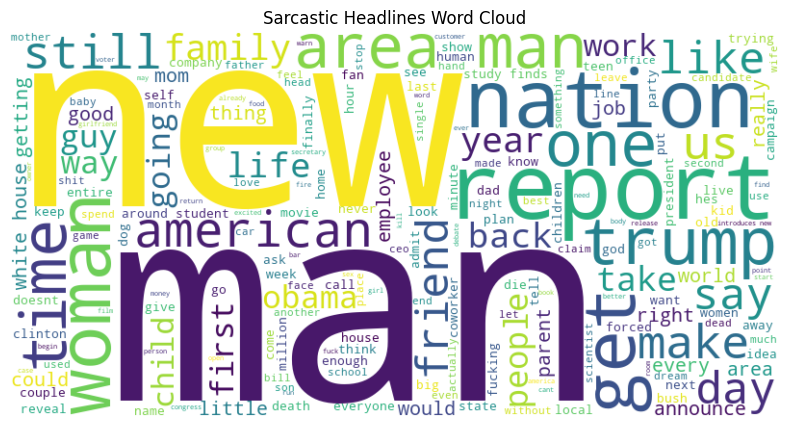

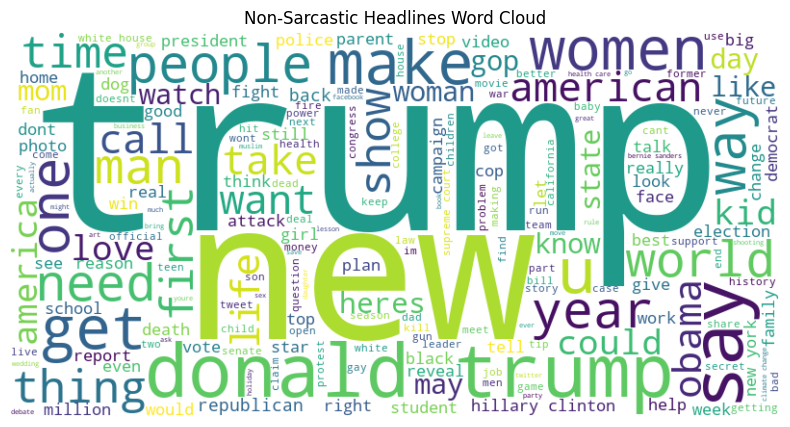

In [24]:
sarcastic_words = " ".join(df[df["is_sarcastic"] == 1]["cleaned_headline"]).lower()
non_sarcastic_words = " ".join(df[df["is_sarcastic"] == 0]["cleaned_headline"]).lower()

sarcastic_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(sarcastic_words)
non_sarcastic_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(non_sarcastic_words)

# Plot sarcastic word cloud
plt.figure(figsize=(10, 5))
plt.imshow(sarcastic_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Sarcastic Headlines Word Cloud")
plt.show()

# Plot non-sarcastic word cloud
plt.figure(figsize=(10, 5))
plt.imshow(non_sarcastic_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Non-Sarcastic Headlines Word Cloud")
plt.show()

## Model

In [113]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2, l1, l1_l2
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

### Function to Plot Results:

In [53]:
def plot_history(history):
    
    plt.figure(figsize=(12, 5))

    # Plot Loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

### Prepare Data

#### Setting Max Length

To ensure consistency in input size for our LSTM model, we need to define a maximum length for headlines. This helps in padding shorter sequences and truncating longer ones, ensuring uniformity across our dataset. For now, we are not limiting vocabulary size, meaning all 29,667 unique words are included. If we run into overfitting, we will consider reducing vocab_size to improve model generalization.


*Why Set a Maximum Length?*
LSTM models require fixed-length sequences, meaning all headlines must be of the same length. However, setting the max length too high can waste memory by adding excessive padding, while setting it too low could truncate important information from longer headlines.

*How Did We Determine the Max Length*
We analyzed the percentile distribution of headline lengths in our dataset:

- Total unique words in dataset: 29,667  
- Total tokens created by tokenizer: 29,681  
- 95% of headlines are 16 words or shorter  
- 99% of headlines are 19 words or shorter  
- 99.9% of headlines are 23 words or shorter  
- Maximum headline length in dataset: 151 words (a single extreme outlier - a sarcastic headline about hot wheels shown below)

We identified one drastically long sarcastic headline (151 words), but since 99.9% of headlines are 23 words or shorter, setting max_length = 23 is a better balance between:
- Retaining almost all headlines without truncation.
- Avoiding unnecessary padding that would occur if we set it to 151 words.

For our model, we will set max_length = 23, ensuring that 99.9% of headlines remain intact while avoiding memory inefficiencies from extreme outliers.

In [43]:
all_words = " ".join(df["cleaned_headline"]).split()
unique_word_count = len(set(all_words))
print(f"Total Unique Words in Dataset: {unique_word_count}")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["cleaned_headline"])
total_tokens = len(tokenizer.word_index)
print(f"Total Tokens Created by Tokenizer: {total_tokens}")

sequences = tokenizer.texts_to_sequences(df["cleaned_headline"])

max_length = max(len(seq) for seq in sequences)
max_95_length = int(np.percentile([len(seq) for seq in sequences], 95))
max_99_length = int(np.percentile([len(seq) for seq in sequences], 99))
max_99_9_length = int(np.percentile([len(seq) for seq in sequences], 99.9))

print(f"95% Percentile of Article Length: {max_95_length}")
print(f"99% Percentile of Article Length: {max_99_length}")
print(f"99.9% Percentile of Article Length: {max_99_9_length}")
print(f"Max Article Length: {max_length}")

Total Unique Words in Dataset: 29667
Total Tokens Created by Tokenizer: 29681
95% Percentile of Article Length: 16
99% Percentile of Article Length: 19
99.9% Percentile of Article Length: 23
Max Article Length: 151


In [44]:
max_length_index = np.argmax([len(seq) for seq in sequences])
longest_headline = df.iloc[max_length_index]["cleaned_headline"]
print(f"Longest Headline: '{longest_headline}'")

Longest Headline: 'hot wheels ranked number one toy for rolling down ramp knocking over dominoes that send marble down a funnel dropping onto teetertotter that yanks on string causing pulley system to raise wooden block propelling series of twine rollers that unwind spring launching tennis ball across room inching tire down slope until it hits power switch activating table fan that blows toy ship with nail attached to it across kiddie pool popping water balloon that fills cup weighing down lever that forces basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumbles down row of hardcover books until handle catches hook attached to lever that causes wooden mallet to slam down on serving spoon catapulting small ball into cup attached by ribbon to lazy susan which spins until it pushes d battery down incline plane tipping over salt shaker to season omelet'


#### Pad Sequences 

LSTM models require fixed-length sequences as input. However, our dataset contains headlines of varying lengths. Padding ensures that all input sequences are of the same length by adding extra zeros (or another placeholder) to shorter sequences and truncating longer ones.

Why is Padding Important?
- Ensures uniform input size for the LSTM model.
- Prevents errors since TensorFlow requires equal-length inputs.
- Maintains context for shorter headlines without distorting longer ones.

In our case, we chose max_length = 23 based on the 99.9% percentile of headline lengths to retain most of the data while avoiding excessive padding.

In [45]:
padded_sequences = pad_sequences(sequences, maxlen=23, padding="post", truncating="post")

#### Split Data

Before training the model, we divide the dataset into:

- Training Set (80% - 22895 labeled headlines): Used to train the LSTM model.
- Testing Set (20%) - 5724 labeled headlines): Used to evaluate the model’s performance on unseen data.

1. Prevents Overfitting: Ensures the model doesn't just memorize patterns but generalizes well.
2. Measures Real-World Accuracy: The testing set simulates how the model will perform on new, unseen headlines.
3. Avoids Data Leakage: Training and testing on the same data would give an inflated accuracy since the model already saw the examples.

Also, the training and test data shape shows 23, which is the length of each headline thanks to the padding.

In [46]:
labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (22895, 23)
Testing Data Shape: (5724, 23)


### Building the LSTM Model

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

### Model Architecture:

#### What is an Embedding Layer?

The **embedding layer** converts words into **dense vector representations** to capture relationships between words beyond simple numeric encoding. Instead of treating words as isolated numbers, embeddings learn relationships between words based on their meaning and usage.

Example:  Let's say we have three words:  
- `"cat"`
- `"dog"`
- `"apple"`

The embedding layer will assign each word a 64-dimensional vector instead of treating them as isolated numbers. 

| Word  | 64-Dimensional Representation |
|--------|--------------------------------------------|
| `"cat"`   | `[0.12, -0.45, 0.78, ..., 0.34, 0.09]` |
| `"dog"`   | `[0.15, -0.50, 0.82, ..., 0.30, 0.12]` |
| `"apple"` | `[-0.34, 0.20, -0.89, ..., 0.41, -0.17]` |

Each row is a 64-number vector that encodes the meaning of the word. Words with similar meanings (e.g., `"cat"` and `"dog"`) will have **closer vector values** compared to unrelated words (e.g., `"apple"`).

**How the Model Learns These Representations**
- At the start, these vectors are **randomly initialized**.
- During training, the model **adjusts** these vectors so that words used in similar contexts get similar embeddings.
- For example, `"cat"` and `"dog"` often appear in similar contexts (e.g., `"The cat is running"` and `"The dog is running"`), so their embeddings will be similar.

**Why Use Embeddings Instead of One-Hot Encoding?**
- *One-hot encoding* represents words as sparse vectors with mostly zeros, which is inefficient for learning relationships.
- *Embeddings* allow the model to capture *semantic meaning*, making it more effective for tasks like sarcasm detection.

---
#### What Does `LSTM(64) and LSTM(32)` Mean?

62 and 32 refer to the number of LSTM units (neurons) in each layer. These units determine how much information the LSTM can store and process.

**How Do LSTM Neurons Work?**

Each LSTM neuron (unit) has three gates that help it learn patterns from sequences:

1. **Forget Gate** → Decides what past information should be discarded.
2. **Input Gate** → Decides what new information to store.
3. **Output Gate** → Decides what information should be passed to the next time step.

For example, in the sentence: *"The movie was amazing, I absolutely loved it."*

The LSTM might remember *"amazing"* and *"loved"* but forget less relevant words like *"The"*.
With `LSTM(64)`, there are 64 such memory cells (neurons) that process different aspects of the sentence simultaneously. They don't store indivudal words, but patterns and relationships learnt from training.

**What Happens Inside `LSTM(64)` and `LSTM(32)`?**



1. The first LSTM (64 units) extracts a rich representation from the text. Each of the 64 LSTM units learns a different pattern in the sequence. Some units might focus on negation words (e.g., *"not"* in *"not bad"*). Others might track sentiment shifts (e.g., *"but"*, as in *"It was bad, but I liked the ending."*).
2. The second LSTM (32 units) compresses this into a more compact representation, like pooling layers in CNNs.

This is why we use 64 units in the first LSTM (to capture broad relationships) and 32 in the second (to summarize information for classification). This reduces the risk of overfitting and makes the model more efficient.

---
#### What is `Dropout(0.5)`?

Dropout is a regularization technique that helps prevent overfitting in neural networks by randomly disabling neurons during training. It's like if you're studying for an exam and decide to study only half ofy our ntoes each time. Over multilple rounds, you become better at understanding the whole subject rather than memorizing specific facts. 

**How droput works:**
- At each training step, 50% of neurons (if 0.5 is used) are randomly turned off.
- This forces the network to learn more robust patterns instead of memorizing specific data points.
- Dropout only applies during training; in testing/inference, all neurons remain active.

**Why this is important:**
- Prevents overfitting → Ensures the model generalizes well to unseen data.
- Encourages redundancy → Forces the network to not rely too much on specific neurons.
- Reduces model complexity → Helps avoid learning spurious correlations.

---
#### What are the Dense layers? `Dense(32)` and `Dense(1)` ?

Dense layers are fully connected layers where each neuron receives input from all neurons in the previous layer. It's similar to the dense layers in a CNN. Here, we 32 neurons that will each be connected to the neuron in the Dense(1) layer. 

**ReLU (Rectified Linear Unit)** is an activation function that introduces non-linearity, allowing the network to learn complex relationships.

Formula:
$$
f(x) = \max(0, x)
$$

- If the input value is positive, it stays the same.
- If the input value is negative, it becomes 0.

Why Use ReLU?
- It avoids the **vanishing gradient problem**, which slows down learning.
- It speeds up training by allowing efficient gradient propagation.
- It is widely used in deep learning models, including CNNs and LSTMs.


---

The `Dense(1, activation = 'sigmoid')` is the final output layer in the model. It only has 1 neuron because we are doing binary classification (sarcastic vs. non-sarcastic), thus it outputs a single probability value between 0 and 1.

The **sigmoid activation function** converts any input into a value between **0 and 1**:

Formula:
$$
f(x) = \frac{1}{1 + e^{-x}}
$$

- If the output is closer to 0, the model predicts non-sarcastic.
- If the output is closer to 1, the model predicts sarcastic.

Why Use Sigmoid?
- It makes the output interpretable as a probability.
- Ideal for **binary classification**, as the output represents how confident the model is in classifying the input.


In [48]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [49]:
import matplotlib.pyplot as plt

def plot_history(history):
    
    plt.figure(figsize=(12,5))

    # plot loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plot.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

### Compile & Train
The model's training accuracy and training loss improve over each epoch from 0.7165 training accuracy in the first epoch to 0.9888 training accuracy in the fifth epoch. And the training loss decreases from 0.5162 in the first epoch to just 0.0338 in the fifth epoch. However, the testing/validation accuracy starts off strong with 0.852 and increases to 0.8590 but slowly decreases to 0.0.848 in the fifth epoch, showing signs of overfitting.

In [50]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.7165 - loss: 0.5162 - val_accuracy: 0.8524 - val_loss: 0.3397
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9297 - loss: 0.1987 - val_accuracy: 0.8590 - val_loss: 0.3460
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.9652 - loss: 0.1018 - val_accuracy: 0.8482 - val_loss: 0.4625
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.9807 - loss: 0.0561 - val_accuracy: 0.8491 - val_loss: 0.5094
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9888 - loss: 0.0338 - val_accuracy: 0.8484 - val_loss: 0.6152


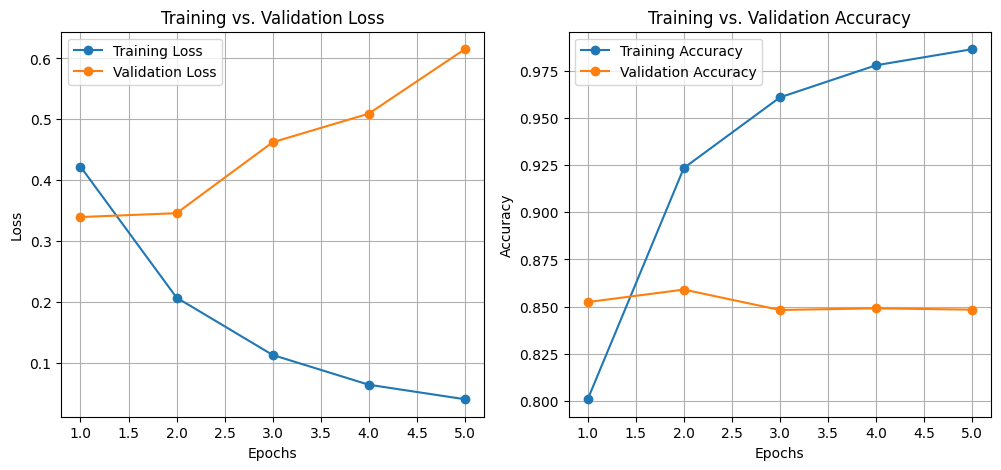

In [54]:
plot_history(history)

## Hyperparameter Tuning
Though the model has a strong validation accuracy, reaching a maximum of **0.8590**, it also shows signs of **overfitting**. This means the model performs well on the training data but struggles to generalize to unseen examples. To address this, we will tune the model’s hyperparameters.

Hyperparameter tuning is the process of systematically adjusting the model’s settings to find the optimal configuration that improves performance. Unlike model parameters (which are learned during training), hyperparameters must be set before training.

**Why Tune Hyperparameters?**
- Helps **reduce overfitting** (so the model generalizes better).
- Improves **accuracy and efficiency** by finding the best model settings.
- Avoids **underfitting** (when the model is too simple to learn meaningful patterns).

| **Hyperparameter** | **What It Controls** | **Effect on Model** |
|--------------------|----------------------|---------------------|
| **LSTM Units** (`64 → 32 → 16`) | Number of neurons per layer | More units capture more patterns but may overfit |
| **Dropout Rate** (`0.5 → 0.6 → 0.7`) | Probability of dropping neurons | Higher dropout reduces overfitting |
| **Batch Size** (`32 → 64 → 128`) | Number of samples processed at once | Smaller = better updates, Larger = faster training |
| **Epochs** (`10 → 20 → 30`) | Number of times the model sees the dataset | Too many = overfitting, Too few = underfitting |
| **Max Sequence Length** (`23 → 19 → 16`) | Number of words per input | Longer retains more context, shorter prevents noise |

By carefully tuning these hyperparameters, we aim to reduce overfitting and improve the model’s ability to detect sarcasm on unseen data.


### Test 1: how do stopwords affect?

We will try and remove the stopwords and see if that better helps the model. Now, we have approximately 100 less unique words in the vocabularly, and 99.9% Percentile of Article Length: 16 compared to the 23 for the previous model. 

In [55]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])
    
df["cleaned_no_stopwords_headline"] = df["cleaned_headline"].apply(remove_stopwords)
df.head()

,is_sarcastic,headline,article_link,cleaned_headline,cleaned_no_stopwords_headline
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,dem rep totally nails why congress is falling ...,dem rep totally nails congress falling short g...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies 9 deliciously different recipes,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word stream...,mother comes pretty close using word streaming...


In [56]:
all_words = " ".join(df["cleaned_no_stopwords_headline"]).split()
unique_word_count = len(set(all_words))
print(f"Total Unique Words in Dataset: {unique_word_count}")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["cleaned_no_stopwords_headline"])
total_tokens = len(tokenizer.word_index)
print(f"Total Tokens Created by Tokenizer: {total_tokens}")

sequences = tokenizer.texts_to_sequences(df["cleaned_no_stopwords_headline"])

max_length = max(len(seq) for seq in sequences)
max_95_length = int(np.percentile([len(seq) for seq in sequences], 95))
max_99_length = int(np.percentile([len(seq) for seq in sequences], 99))
max_99_9_length = int(np.percentile([len(seq) for seq in sequences], 99.9))

print(f"95% Percentile of Article Length: {max_95_length}")
print(f"99% Percentile of Article Length: {max_99_length}")
print(f"99.9% Percentile of Article Length: {max_99_9_length}")
print(f"Max Article Length: {max_length}")

Total Unique Words in Dataset: 29533
Total Tokens Created by Tokenizer: 29533
95% Percentile of Article Length: 11
99% Percentile of Article Length: 13
99.9% Percentile of Article Length: 16
Max Article Length: 106


In [57]:
padded_sequences = pad_sequences(sequences, maxlen=16, padding="post", truncating="post")

labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (22895, 16)
Testing Data Shape: (5724, 16)


**Results:** The model's accuracy dropped from **0.8590** in the previous model (with stop words included) to **0.8073** when stop words were removed. This suggests that the LSTM model relies on stop words to better understand and detect sarcasm. Given this impact, we will proceed with the model that includes stop words.

In [58]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.6807 - loss: 0.5663 - val_accuracy: 0.8070 - val_loss: 0.4124
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.9083 - loss: 0.2418 - val_accuracy: 0.8073 - val_loss: 0.4492
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.9549 - loss: 0.1289 - val_accuracy: 0.7998 - val_loss: 0.6468
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.9741 - loss: 0.0766 - val_accuracy: 0.8014 - val_loss: 0.6566
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9841 - loss: 0.0487 - val_accuracy: 0.7973 - val_loss: 1.0090


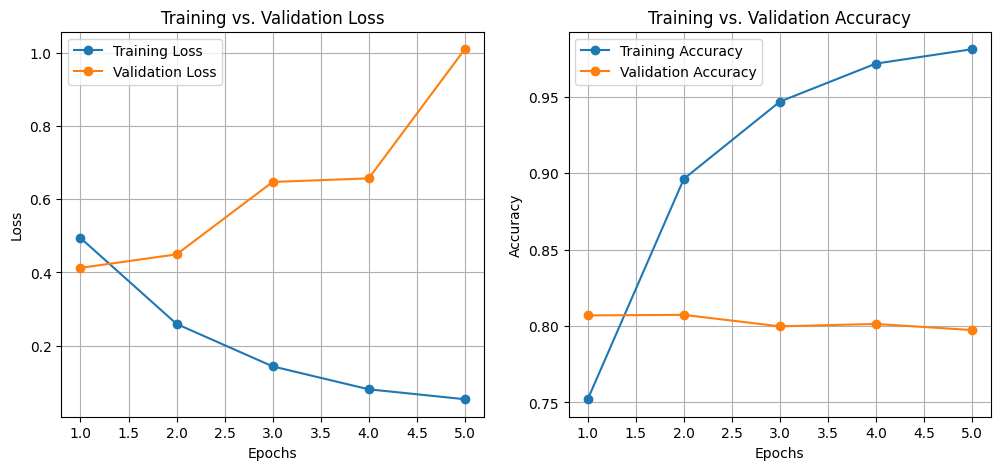

In [59]:
plot_history(history)

### Test 2: how will train/test split affect?
Increasing train/test split from 20/80 to 25/75 doesn't better the testing accuracy / overfitting.
However, decreasing train/test split from 20/80 to 15/85 to 10/90 to 5/95 increased the training and testing accuracy and decreased amount of overfitting. The highest testing accuracy we got was with 5/95 model **0.8784**. With 1/99 split, it decreased accuracy.

In [60]:
all_words = " ".join(df["cleaned_headline"]).split()
unique_word_count = len(set(all_words))
print(f"Total Unique Words in Dataset: {unique_word_count}")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["cleaned_headline"])
total_tokens = len(tokenizer.word_index)
print(f"Total Tokens Created by Tokenizer: {total_tokens}")

sequences = tokenizer.texts_to_sequences(df["cleaned_headline"])

max_length = max(len(seq) for seq in sequences)
max_95_length = int(np.percentile([len(seq) for seq in sequences], 95))
max_99_length = int(np.percentile([len(seq) for seq in sequences], 99))
max_99_9_length = int(np.percentile([len(seq) for seq in sequences], 99.9))

print(f"95% Percentile of Article Length: {max_95_length}")
print(f"99% Percentile of Article Length: {max_99_length}")
print(f"99.9% Percentile of Article Length: {max_99_9_length}")
print(f"Max Article Length: {max_length}")

Total Unique Words in Dataset: 29667
Total Tokens Created by Tokenizer: 29681
95% Percentile of Article Length: 16
99% Percentile of Article Length: 19
99.9% Percentile of Article Length: 23
Max Article Length: 151


In [61]:
padded_sequences = pad_sequences(sequences, maxlen=23, padding="post", truncating="post")

labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.25, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (21464, 23)
Testing Data Shape: (7155, 23)


In [62]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.7051 - loss: 0.5253 - val_accuracy: 0.8444 - val_loss: 0.3517
Epoch 2/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.9345 - loss: 0.1862 - val_accuracy: 0.8468 - val_loss: 0.3484
Epoch 3/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.9680 - loss: 0.0970 - val_accuracy: 0.8275 - val_loss: 0.4925
Epoch 4/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.9813 - loss: 0.0563 - val_accuracy: 0.8319 - val_loss: 0.4974
Epoch 5/5
671/671 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9892 - loss: 0.0351 - val_accuracy: 0.8300 - val_loss: 0.6298


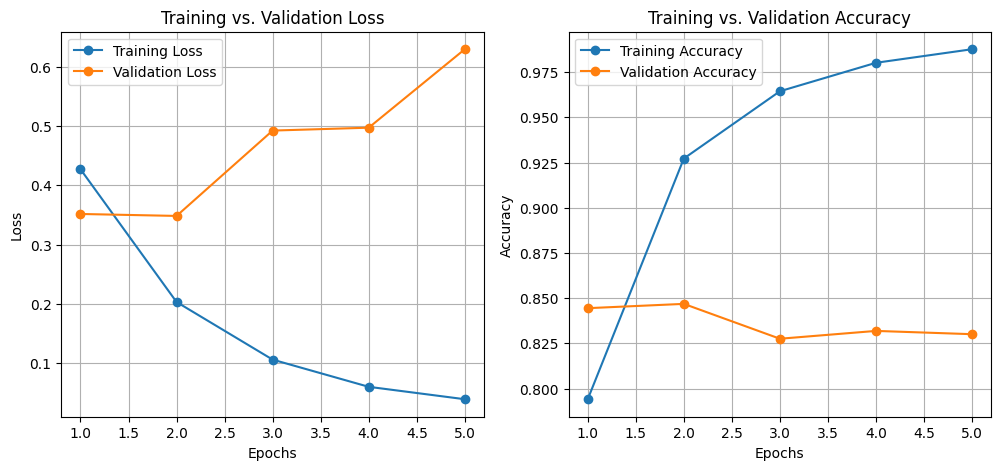

In [63]:
plot_history(history)

train/test split of 15/85

In [64]:
padded_sequences = pad_sequences(sequences, maxlen=23, padding="post", truncating="post")

labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.15, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (24326, 23)
Testing Data Shape: (4293, 23)


In [65]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
761/761 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.7396 - loss: 0.4996 - val_accuracy: 0.8581 - val_loss: 0.3261
Epoch 2/5
761/761 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.9288 - loss: 0.1904 - val_accuracy: 0.8556 - val_loss: 0.3536
Epoch 3/5
761/761 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.9697 - loss: 0.0971 - val_accuracy: 0.8460 - val_loss: 0.4248
Epoch 4/5
761/761 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.9825 - loss: 0.0545 - val_accuracy: 0.8460 - val_loss: 0.6284
Epoch 5/5
761/761 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.9902 - loss: 0.0326 - val_accuracy: 0.8400 - val_loss: 0.6403


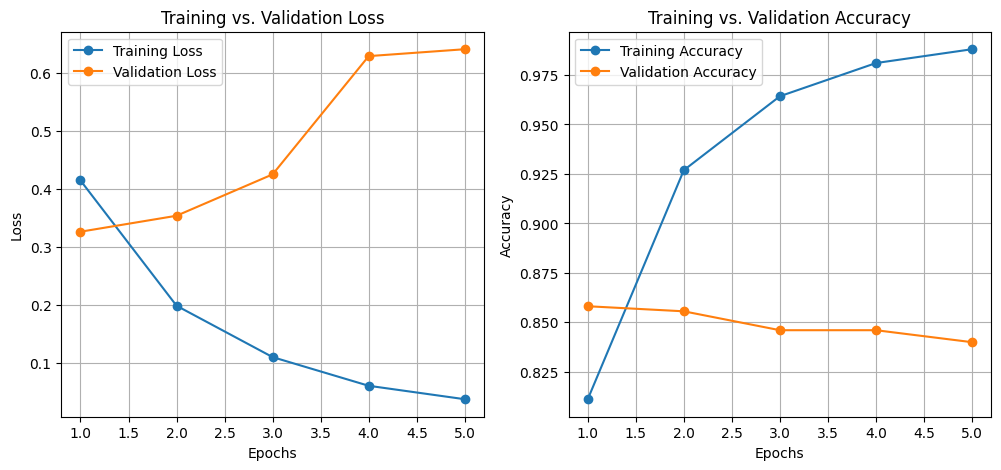

In [66]:
plot_history(history)

train/test split 10/90

In [67]:
padded_sequences = pad_sequences(sequences, maxlen=23, padding="post", truncating="post")

labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.10, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (25757, 23)
Testing Data Shape: (2862, 23)


Epoch 1/5
805/805 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.7327 - loss: 0.5057 - val_accuracy: 0.8641 - val_loss: 0.3133
Epoch 2/5
805/805 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.9293 - loss: 0.1953 - val_accuracy: 0.8669 - val_loss: 0.3416
Epoch 3/5
805/805 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9652 - loss: 0.1018 - val_accuracy: 0.8620 - val_loss: 0.3849
Epoch 4/5
805/805 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9800 - loss: 0.0595 - val_accuracy: 0.8550 - val_loss: 0.5371
Epoch 5/5
805/805 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.9885 - loss: 0.0348 - val_accuracy: 0.8477 - val_loss: 0.6283


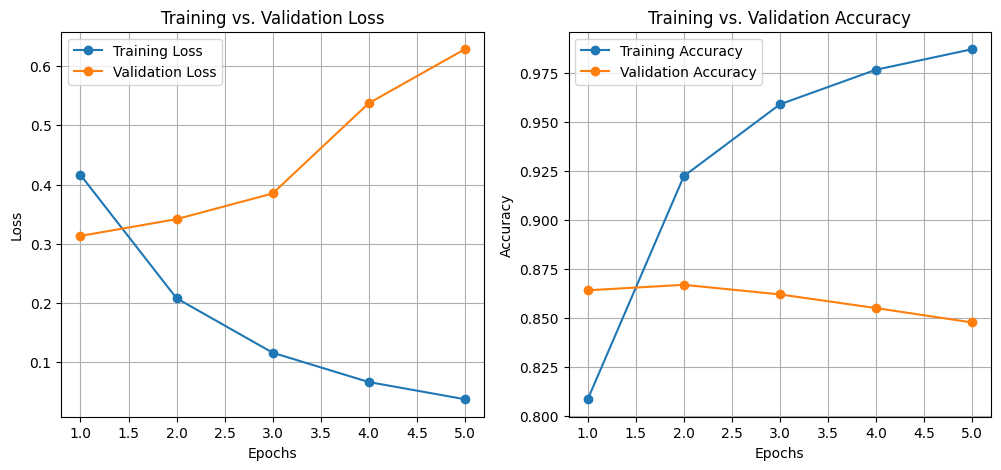

In [68]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

train/test split 5/95

In [69]:
padded_sequences = pad_sequences(sequences, maxlen=23, padding="post", truncating="post")

labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.05, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (27188, 23)
Testing Data Shape: (1431, 23)


Epoch 1/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.7270 - loss: 0.5020 - val_accuracy: 0.8735 - val_loss: 0.2980
Epoch 2/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.9298 - loss: 0.1916 - val_accuracy: 0.8784 - val_loss: 0.2985
Epoch 3/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9629 - loss: 0.1019 - val_accuracy: 0.8630 - val_loss: 0.3220
Epoch 4/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.9830 - loss: 0.0568 - val_accuracy: 0.8567 - val_loss: 0.4833
Epoch 5/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.9879 - loss: 0.0374 - val_accuracy: 0.8519 - val_loss: 0.5585


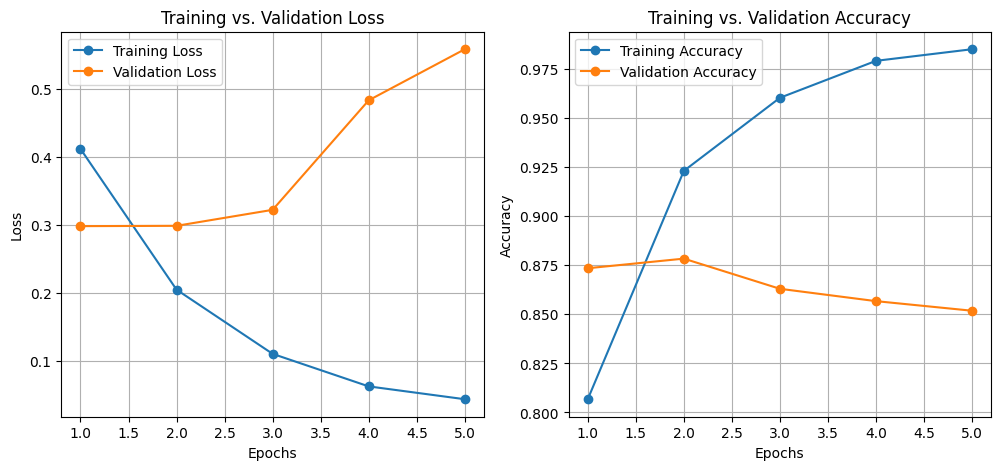

In [70]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

In [115]:
padded_sequences = pad_sequences(sequences, maxlen=23, padding="post", truncating="post")

labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.01, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (28332, 23)
Testing Data Shape: (287, 23)


Epoch 1/5
886/886 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7414 - loss: 0.4910 - val_accuracy: 0.8328 - val_loss: 0.3708
Epoch 2/5
886/886 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9292 - loss: 0.1922 - val_accuracy: 0.8432 - val_loss: 0.3709
Epoch 3/5
886/886 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.9689 - loss: 0.0939 - val_accuracy: 0.8223 - val_loss: 0.5403
Epoch 4/5
886/886 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9838 - loss: 0.0489 - val_accuracy: 0.8467 - val_loss: 0.5290
Epoch 5/5
886/886 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9906 - loss: 0.0284 - val_accuracy: 0.8397 - val_loss: 0.6154


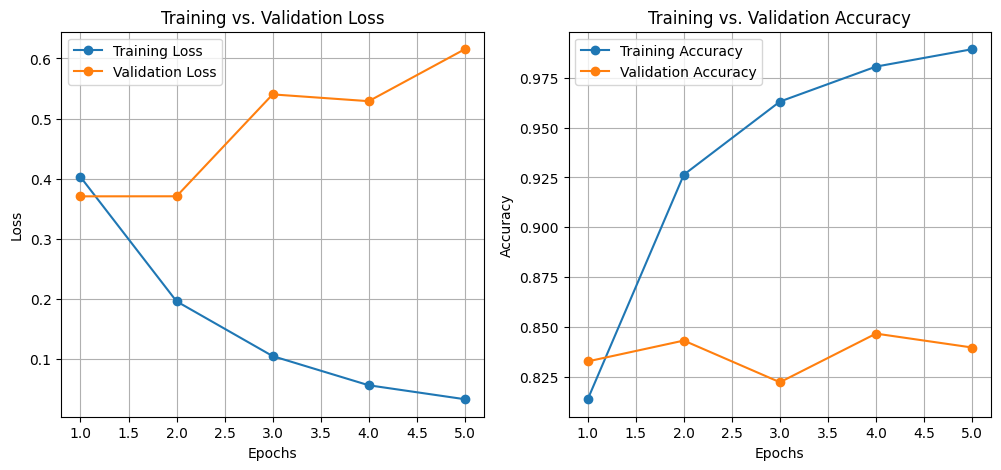

In [116]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

### Test 3: How does dropout affect?
To accurately assess the impact of dropout, we will revert to the original 80/20 train-test split, ensuring that all other parameters remain unchanged. This allows us to isolate the effect of dropout and directly compare it to the **baseline model**.

We'll revert back to a 20/80 split for this so we can see how changing one single parameter will affect since we're comparing to base model. Now, we'll increase droput from 0.5 to 0.6 and 0.7, and also see how decreasing it to 0.4 and 0.3 will affect as well. 

Results: as expected, increasing dropout stabilzed the overfitting. In the plots, y oucan see that the testing accuracy is flatter and flucuate less. However, the testing accuracy is slightly lower than the ones in baseline. 

In [71]:
padded_sequences = pad_sequences(sequences, maxlen=23, padding="post", truncating="post")

labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.20, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (22895, 23)
Testing Data Shape: (5724, 23)


#### Droput: 0.6

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.6789 - loss: 0.5459 - val_accuracy: 0.8532 - val_loss: 0.3304
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9306 - loss: 0.1996 - val_accuracy: 0.8539 - val_loss: 0.3769
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9693 - loss: 0.0973 - val_accuracy: 0.8505 - val_loss: 0.5316
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.9825 - loss: 0.0519 - val_accuracy: 0.8447 - val_loss: 0.5682
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9912 - loss: 0.0284 - val_accuracy: 0.8447 - val_loss: 0.6030


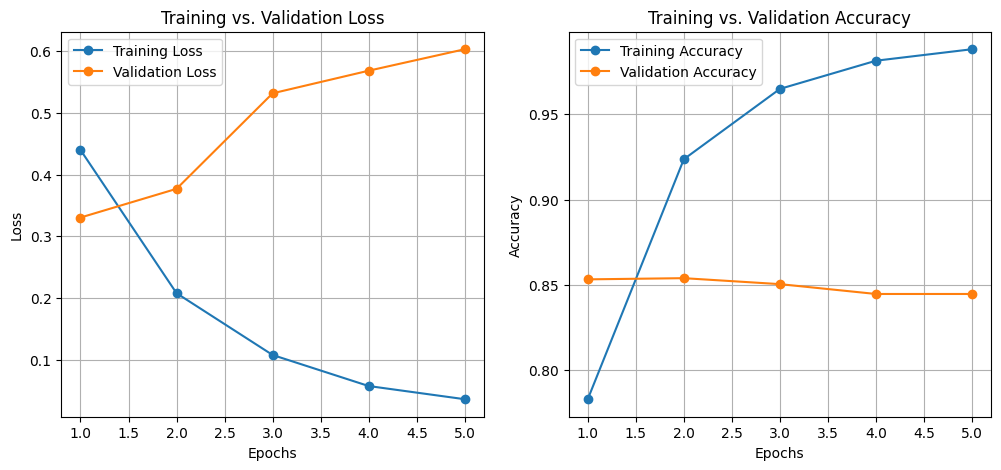

In [72]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.6),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

#### Droput: 0.7

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.6918 - loss: 0.5609 - val_accuracy: 0.8477 - val_loss: 0.3404
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9224 - loss: 0.2264 - val_accuracy: 0.8539 - val_loss: 0.3583
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9642 - loss: 0.1100 - val_accuracy: 0.8503 - val_loss: 0.4241
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9814 - loss: 0.0606 - val_accuracy: 0.8424 - val_loss: 0.5779
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9883 - loss: 0.0395 - val_accuracy: 0.8470 - val_loss: 0.7533


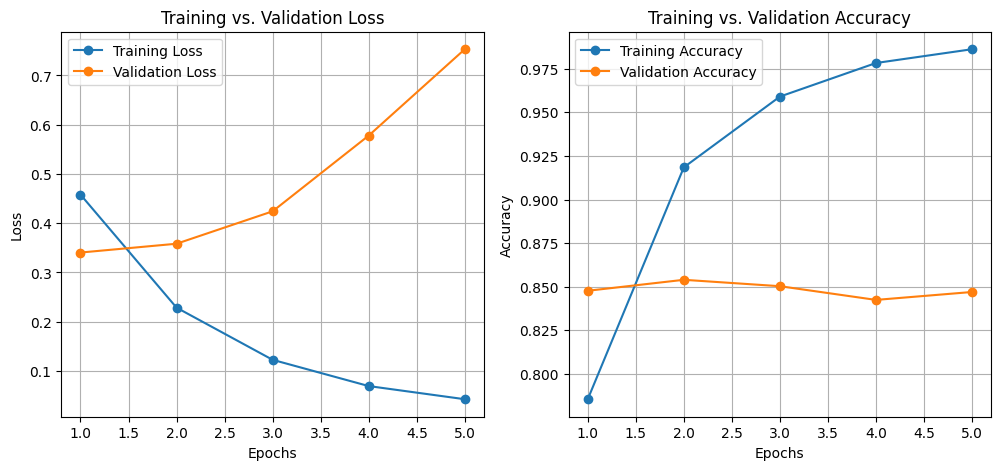

In [73]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.7),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

#### Droput: 0.4

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.7328 - loss: 0.5051 - val_accuracy: 0.8470 - val_loss: 0.3385
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9286 - loss: 0.1950 - val_accuracy: 0.8508 - val_loss: 0.3747
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.9689 - loss: 0.0947 - val_accuracy: 0.8370 - val_loss: 0.4221
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9816 - loss: 0.0614 - val_accuracy: 0.8471 - val_loss: 0.5531
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.9904 - loss: 0.0309 - val_accuracy: 0.8433 - val_loss: 0.6674


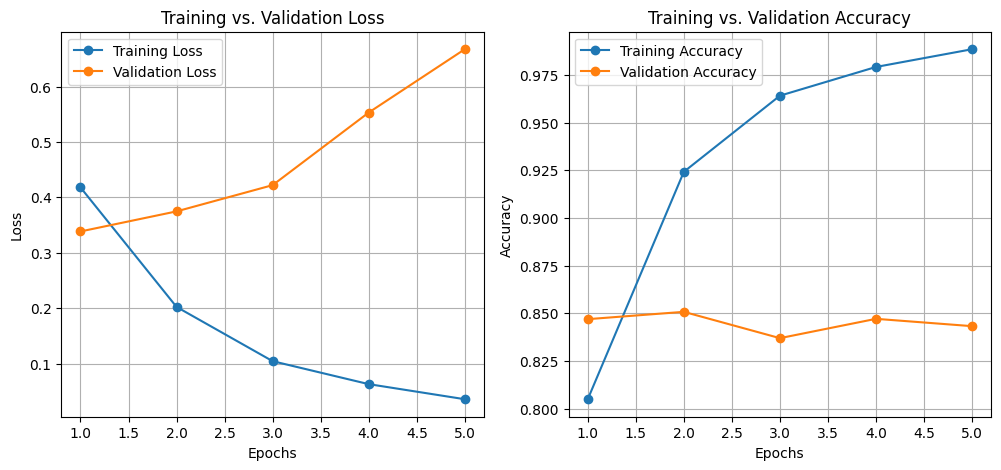

In [74]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.4),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

#### Droput: 0.3

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.7142 - loss: 0.5130 - val_accuracy: 0.8531 - val_loss: 0.3396
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.9290 - loss: 0.1920 - val_accuracy: 0.8588 - val_loss: 0.3504
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.9693 - loss: 0.0939 - val_accuracy: 0.8515 - val_loss: 0.4183
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9843 - loss: 0.0530 - val_accuracy: 0.8447 - val_loss: 0.6284
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9898 - loss: 0.0297 - val_accuracy: 0.8419 - val_loss: 0.6352


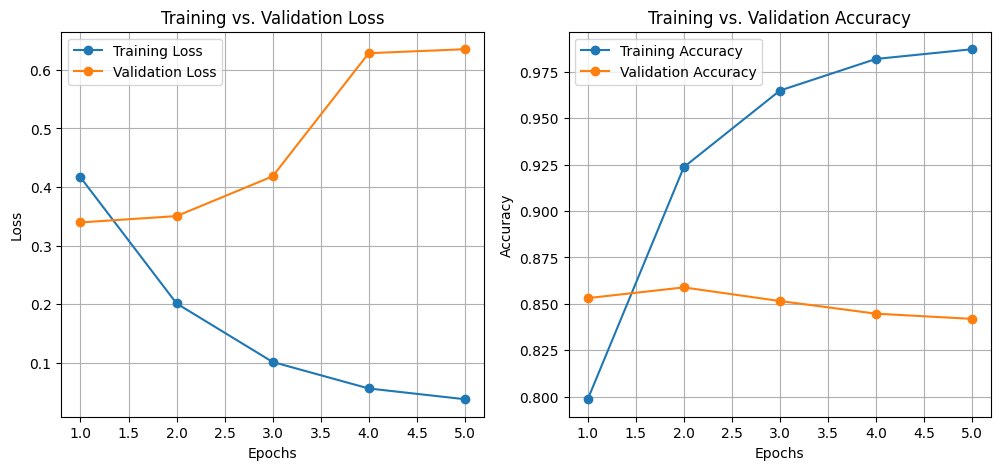

In [75]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.3),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

### How do LSTM() layers affect?

Results: Changing the LSTM() layers - number of total layers and the layers individually, didn't have as large of an affect. Most had a testing accuracy of around 0.85 with some lower and some higher. 

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5655 - loss: 0.6623 - val_accuracy: 0.8360 - val_loss: 0.3754
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8948 - loss: 0.2837 - val_accuracy: 0.8562 - val_loss: 0.3238
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.9504 - loss: 0.1583 - val_accuracy: 0.8526 - val_loss: 0.4135
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9726 - loss: 0.0924 - val_accuracy: 0.8557 - val_loss: 0.4723
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9839 - loss: 0.0543 - val_accuracy: 0.8487 - val_loss: 0.6278


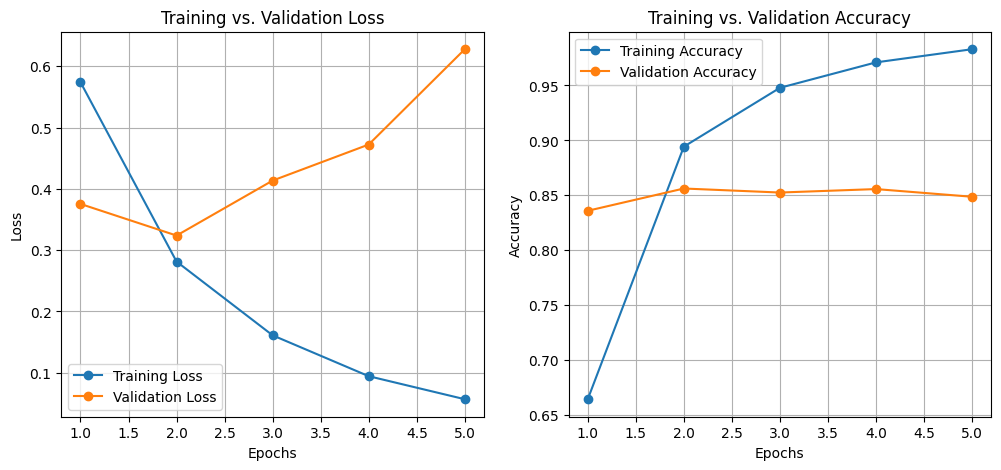

In [77]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(8),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.6584 - loss: 0.5705 - val_accuracy: 0.8443 - val_loss: 0.3580
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9245 - loss: 0.2139 - val_accuracy: 0.8557 - val_loss: 0.3486
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9643 - loss: 0.1102 - val_accuracy: 0.8506 - val_loss: 0.4635
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9801 - loss: 0.0590 - val_accuracy: 0.8485 - val_loss: 0.6554
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9875 - loss: 0.0402 - val_accuracy: 0.8445 - val_loss: 0.6882


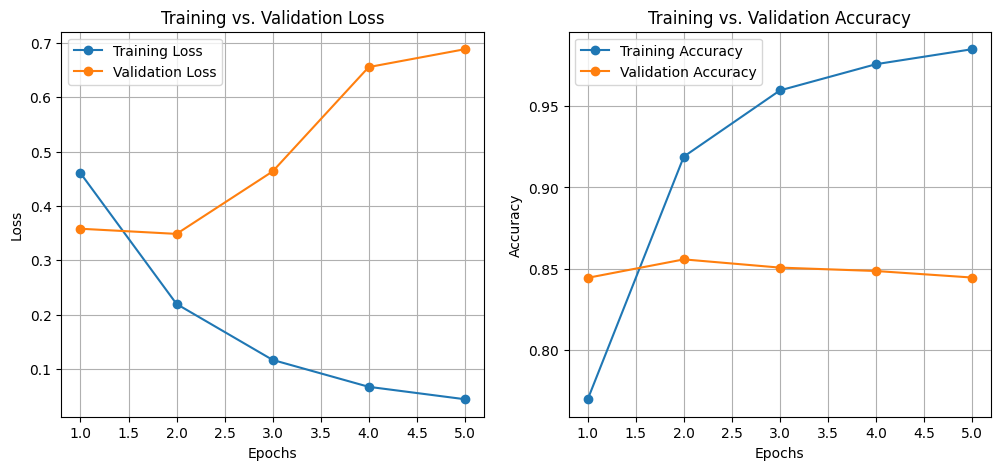

In [84]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(16),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.7048 - loss: 0.5276 - val_accuracy: 0.8543 - val_loss: 0.3315
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9283 - loss: 0.1985 - val_accuracy: 0.8454 - val_loss: 0.3960
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9628 - loss: 0.1097 - val_accuracy: 0.8492 - val_loss: 0.4260
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9803 - loss: 0.0623 - val_accuracy: 0.8391 - val_loss: 0.6894
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9887 - loss: 0.0356 - val_accuracy: 0.8414 - val_loss: 0.7789


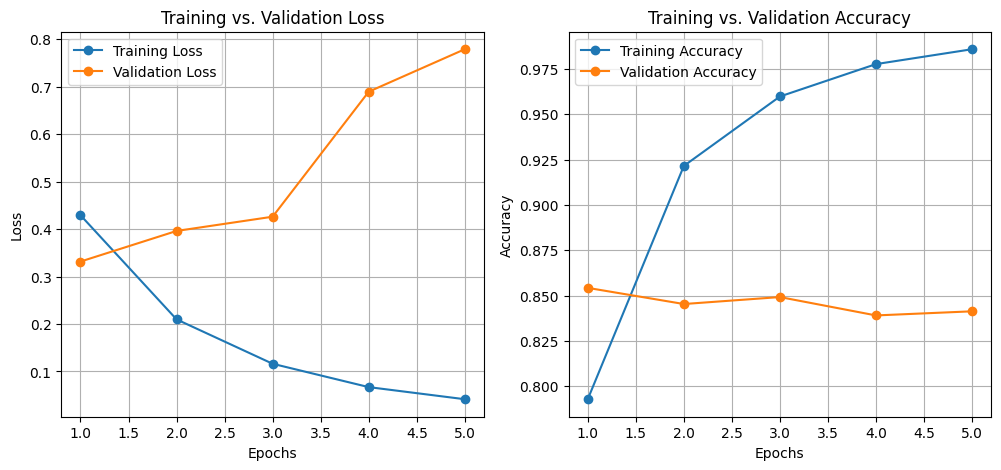

In [85]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.7057 - loss: 0.5187 - val_accuracy: 0.8450 - val_loss: 0.3452
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9273 - loss: 0.2000 - val_accuracy: 0.8450 - val_loss: 0.3512
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9672 - loss: 0.1029 - val_accuracy: 0.8400 - val_loss: 0.4236
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9772 - loss: 0.0675 - val_accuracy: 0.8417 - val_loss: 0.5468
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9884 - loss: 0.0375 - val_accuracy: 0.8403 - val_loss: 0.7555


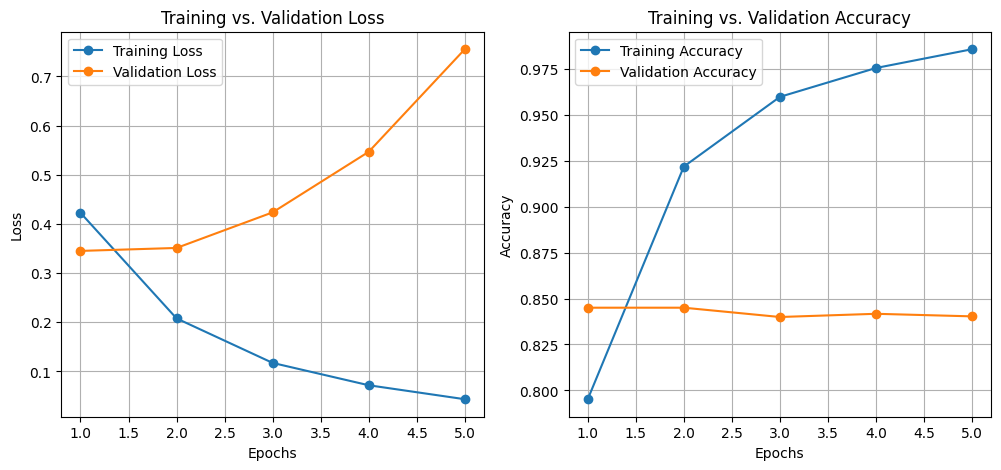

In [86]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.7275 - loss: 0.5056 - val_accuracy: 0.8316 - val_loss: 0.3674
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9280 - loss: 0.1904 - val_accuracy: 0.8543 - val_loss: 0.3983
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9638 - loss: 0.1038 - val_accuracy: 0.8394 - val_loss: 0.5299
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9773 - loss: 0.0655 - val_accuracy: 0.8356 - val_loss: 0.5302
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9877 - loss: 0.0366 - val_accuracy: 0.8381 - val_loss: 0.6798


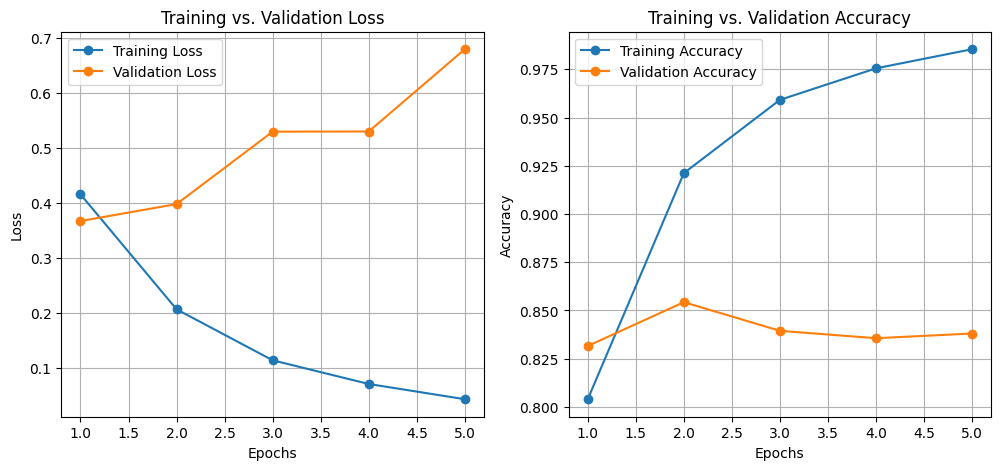

In [87]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(128),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.6552 - loss: 0.5898 - val_accuracy: 0.8496 - val_loss: 0.3379
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9203 - loss: 0.2193 - val_accuracy: 0.8571 - val_loss: 0.3570
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9631 - loss: 0.1140 - val_accuracy: 0.8534 - val_loss: 0.4450
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9794 - loss: 0.0615 - val_accuracy: 0.8471 - val_loss: 0.5522
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9904 - loss: 0.0318 - val_accuracy: 0.8480 - val_loss: 0.7965


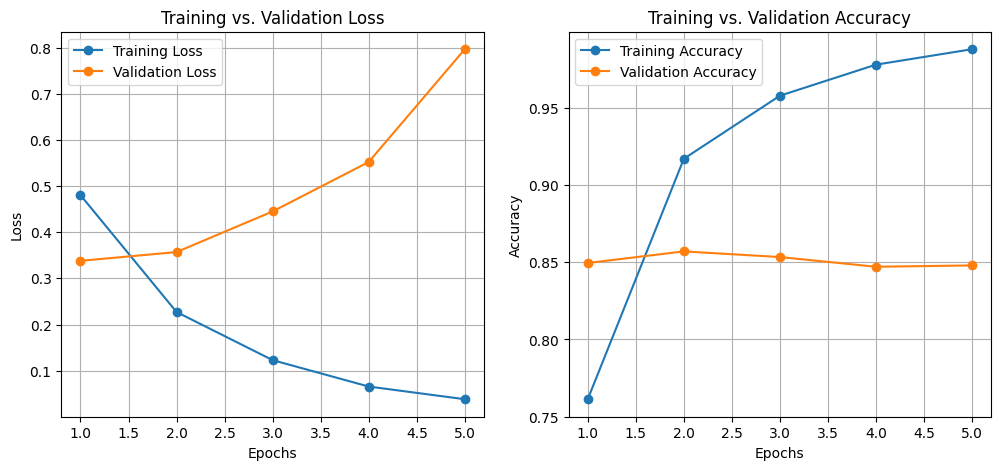

In [88]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(16, return_sequences = True),
    LSTM(8),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.6471 - loss: 0.5795 - val_accuracy: 0.8454 - val_loss: 0.3498
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9203 - loss: 0.2199 - val_accuracy: 0.8622 - val_loss: 0.3390
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9667 - loss: 0.1103 - val_accuracy: 0.8477 - val_loss: 0.4573
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9836 - loss: 0.0548 - val_accuracy: 0.8492 - val_loss: 0.5625
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9899 - loss: 0.0346 - val_accuracy: 0.8454 - val_loss: 0.7224


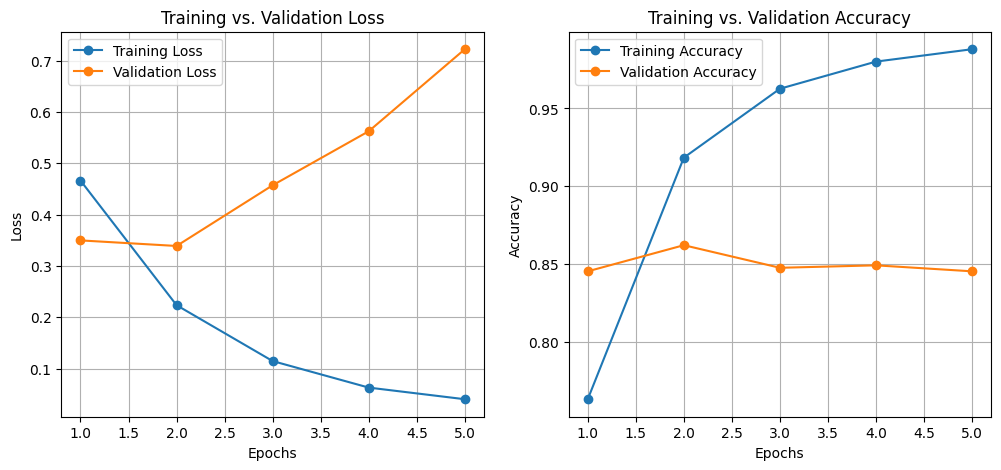

In [89]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(32, return_sequences = True),
    LSTM(16),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.7303 - loss: 0.5156 - val_accuracy: 0.8487 - val_loss: 0.3532
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - accuracy: 0.9327 - loss: 0.1909 - val_accuracy: 0.8538 - val_loss: 0.3335
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - accuracy: 0.9693 - loss: 0.0965 - val_accuracy: 0.8365 - val_loss: 0.4880
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - accuracy: 0.9829 - loss: 0.0567 - val_accuracy: 0.8491 - val_loss: 0.6483
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - accuracy: 0.9912 - loss: 0.0297 - val_accuracy: 0.8440 - val_loss: 0.6395


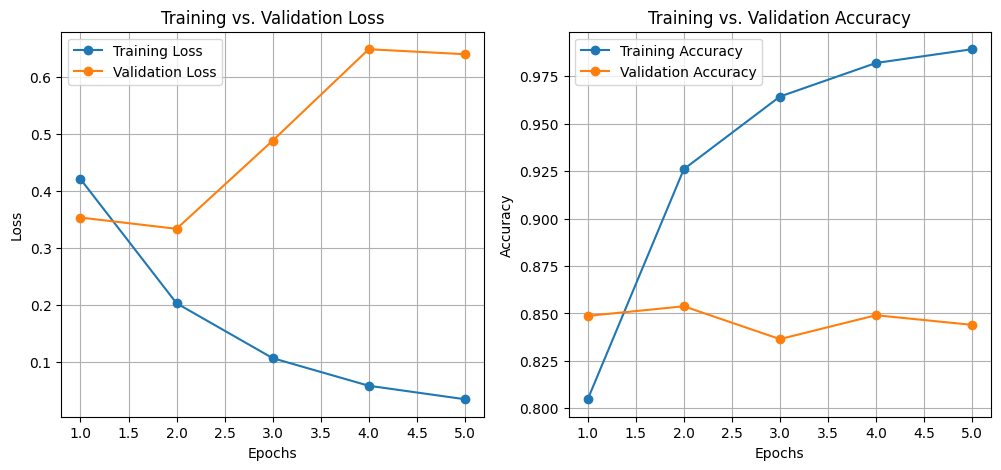

In [90]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(128, return_sequences = True),
    LSTM(64),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step - accuracy: 0.6991 - loss: 0.5533 - val_accuracy: 0.8468 - val_loss: 0.3532
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9202 - loss: 0.2239 - val_accuracy: 0.8489 - val_loss: 0.3752
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.9621 - loss: 0.1204 - val_accuracy: 0.8468 - val_loss: 0.5086
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.9790 - loss: 0.0721 - val_accuracy: 0.8461 - val_loss: 0.6121
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.9884 - loss: 0.0395 - val_accuracy: 0.8457 - val_loss: 0.6583


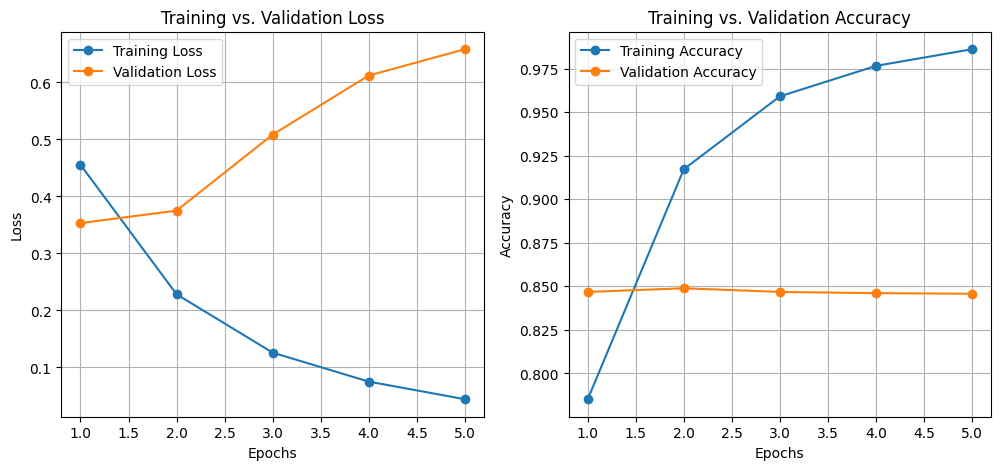

In [91]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(32, return_sequences = True),
    LSTM(16, return_sequences = True),
    LSTM(8),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - accuracy: 0.7295 - loss: 0.5194 - val_accuracy: 0.8527 - val_loss: 0.3433
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9306 - loss: 0.1919 - val_accuracy: 0.8552 - val_loss: 0.3474
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.9674 - loss: 0.1038 - val_accuracy: 0.8478 - val_loss: 0.4638
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9803 - loss: 0.0633 - val_accuracy: 0.8489 - val_loss: 0.5634
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9892 - loss: 0.0352 - val_accuracy: 0.8473 - val_loss: 0.6737


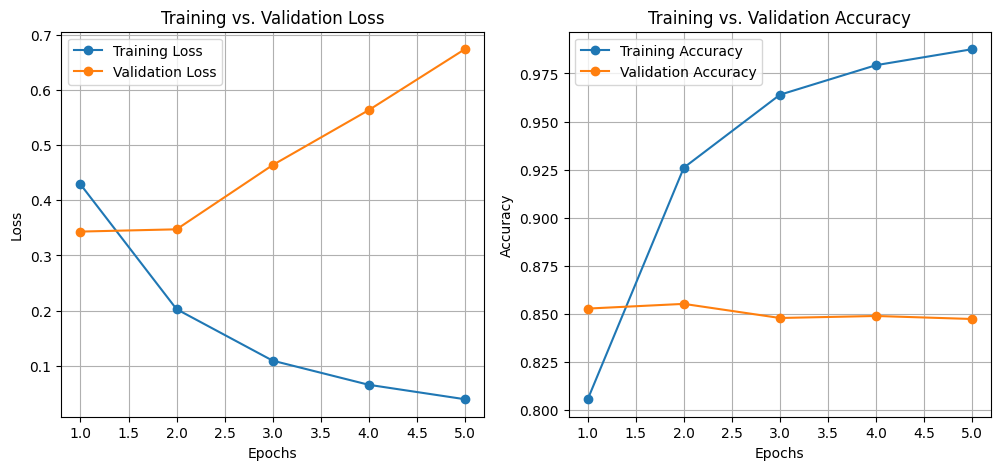

In [92]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32, return_sequences = True),
    LSTM(16),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.7090 - loss: 0.5727 - val_accuracy: 0.8445 - val_loss: 0.3475
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 53s 74ms/step - accuracy: 0.9160 - loss: 0.2337 - val_accuracy: 0.8459 - val_loss: 0.3387
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 53s 74ms/step - accuracy: 0.9611 - loss: 0.1160 - val_accuracy: 0.8223 - val_loss: 0.4355
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.9789 - loss: 0.0691 - val_accuracy: 0.8436 - val_loss: 0.5345
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 53s 74ms/step - accuracy: 0.9871 - loss: 0.0413 - val_accuracy: 0.8375 - val_loss: 0.6221


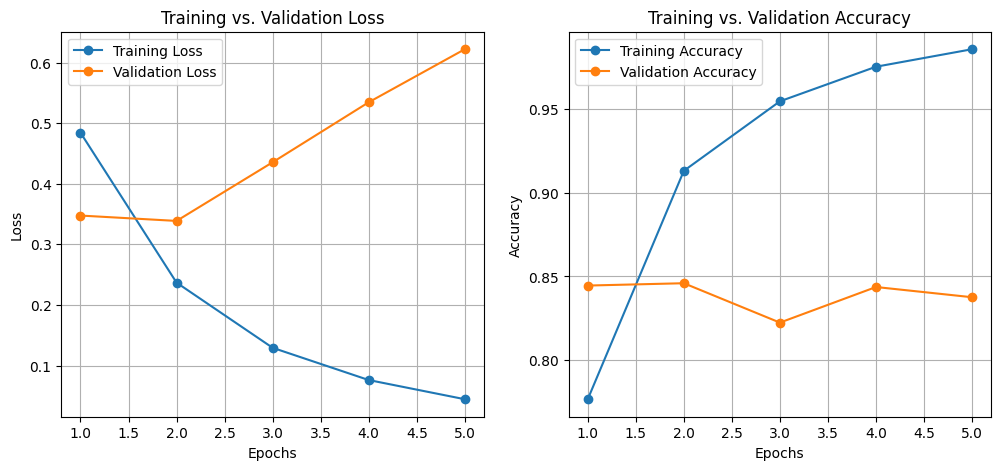

In [93]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(128, return_sequences = True),
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 113s 142ms/step - accuracy: 0.7470 - loss: 0.4937 - val_accuracy: 0.8531 - val_loss: 0.3444
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 99s 139ms/step - accuracy: 0.9296 - loss: 0.1999 - val_accuracy: 0.8471 - val_loss: 0.4009
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 100s 140ms/step - accuracy: 0.9627 - loss: 0.1142 - val_accuracy: 0.8449 - val_loss: 0.4457
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 95s 133ms/step - accuracy: 0.9778 - loss: 0.0685 - val_accuracy: 0.8524 - val_loss: 0.4886
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9863 - loss: 0.0436 - val_accuracy: 0.8387 - val_loss: 0.5885


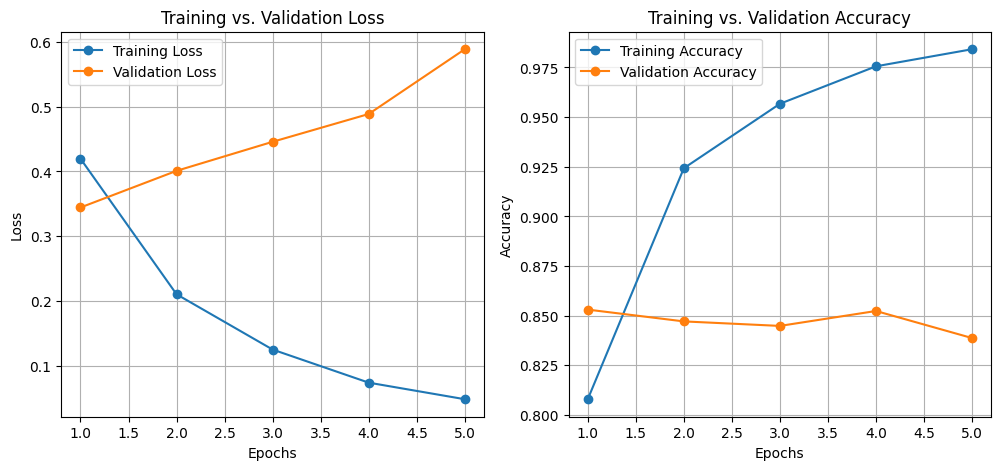

In [94]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(256, return_sequences = True),
    LSTM(128, return_sequences = True),
    LSTM(64),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - accuracy: 0.7388 - loss: 0.5101 - val_accuracy: 0.8431 - val_loss: 0.3615
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.9284 - loss: 0.2055 - val_accuracy: 0.8340 - val_loss: 0.3985
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.9642 - loss: 0.1073 - val_accuracy: 0.8487 - val_loss: 0.4771
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9803 - loss: 0.0607 - val_accuracy: 0.8513 - val_loss: 0.5055
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9882 - loss: 0.0381 - val_accuracy: 0.8436 - val_loss: 0.5938


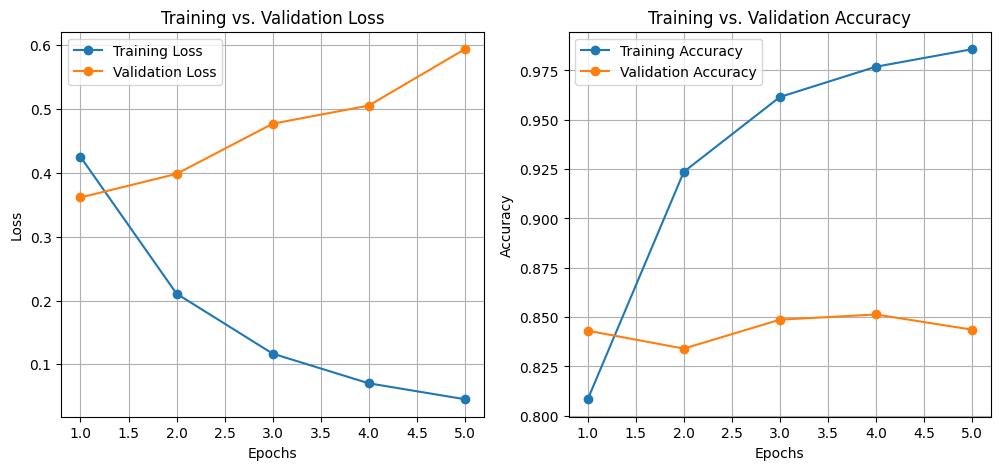

In [95]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(128, return_sequences = True),
    LSTM(64, return_sequences = True),
    LSTM(32, return_sequences = True),
    LSTM(16),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.7189 - loss: 0.5392 - val_accuracy: 0.8466 - val_loss: 0.3482
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.9262 - loss: 0.2169 - val_accuracy: 0.8494 - val_loss: 0.3948
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.9627 - loss: 0.1258 - val_accuracy: 0.8428 - val_loss: 0.4273
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.9761 - loss: 0.0772 - val_accuracy: 0.8358 - val_loss: 0.5864
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.9859 - loss: 0.0516 - val_accuracy: 0.8478 - val_loss: 0.6294


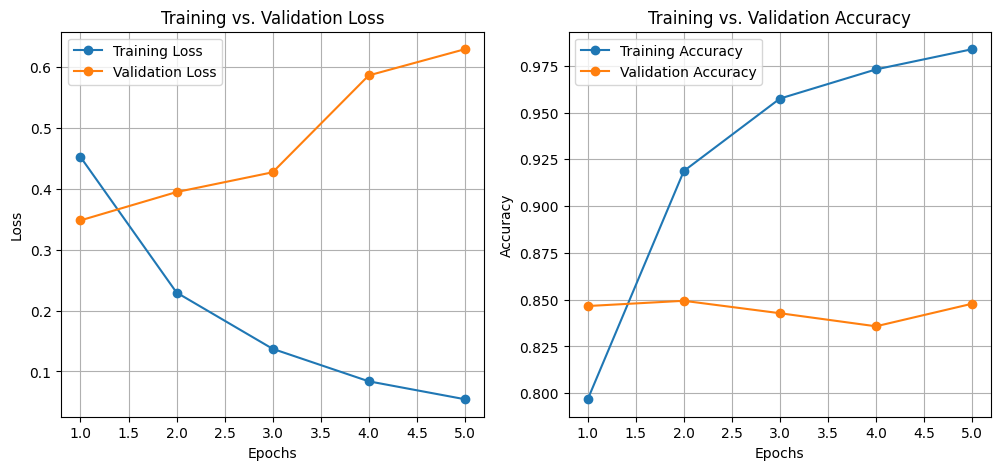

In [97]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(128, return_sequences = True),
    LSTM(64, return_sequences = True),
    LSTM(32, return_sequences = True),
    LSTM(16, return_sequences = True),
    LSTM(8),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

### Changing Dense layers Affect:

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.7195 - loss: 0.5009 - val_accuracy: 0.8484 - val_loss: 0.3417
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9307 - loss: 0.1921 - val_accuracy: 0.8566 - val_loss: 0.3310
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.9682 - loss: 0.1019 - val_accuracy: 0.8506 - val_loss: 0.3864
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9823 - loss: 0.0518 - val_accuracy: 0.8456 - val_loss: 0.5383
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9887 - loss: 0.0342 - val_accuracy: 0.8401 - val_loss: 0.7118


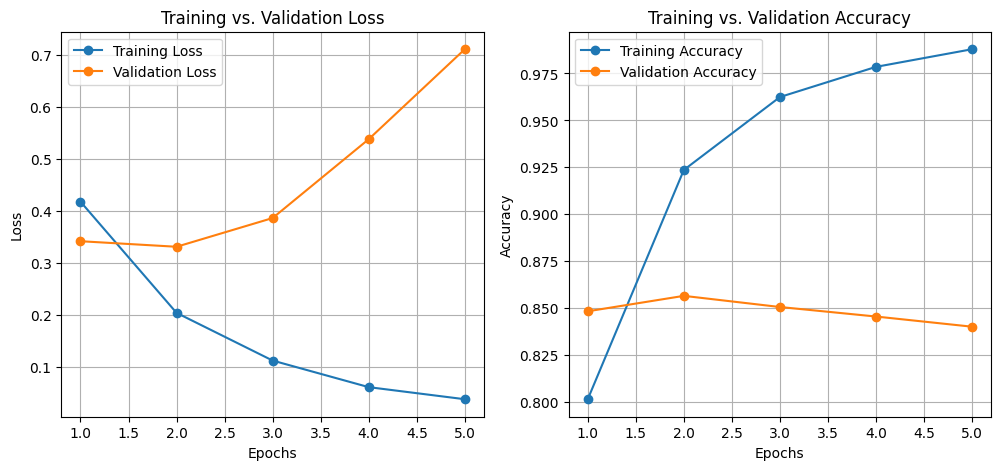

In [98]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.7169 - loss: 0.5207 - val_accuracy: 0.8506 - val_loss: 0.3448
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9307 - loss: 0.1986 - val_accuracy: 0.8512 - val_loss: 0.3592
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9688 - loss: 0.0994 - val_accuracy: 0.8442 - val_loss: 0.3751
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9836 - loss: 0.0535 - val_accuracy: 0.8459 - val_loss: 0.6077
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9883 - loss: 0.0363 - val_accuracy: 0.8321 - val_loss: 0.5030


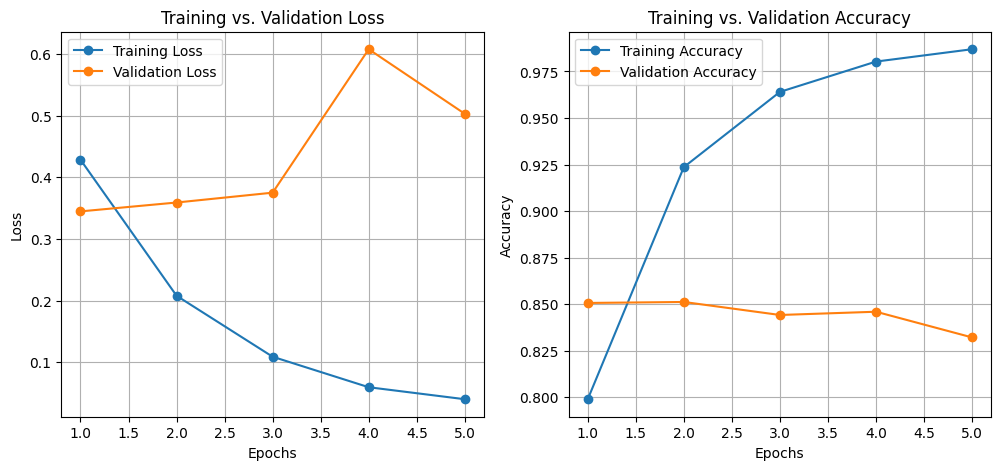

In [99]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(16, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.7307 - loss: 0.5057 - val_accuracy: 0.8583 - val_loss: 0.3334
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9322 - loss: 0.1886 - val_accuracy: 0.8550 - val_loss: 0.3762
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9697 - loss: 0.0924 - val_accuracy: 0.8489 - val_loss: 0.4355
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9819 - loss: 0.0550 - val_accuracy: 0.8464 - val_loss: 0.5753
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9890 - loss: 0.0319 - val_accuracy: 0.8337 - val_loss: 0.6430


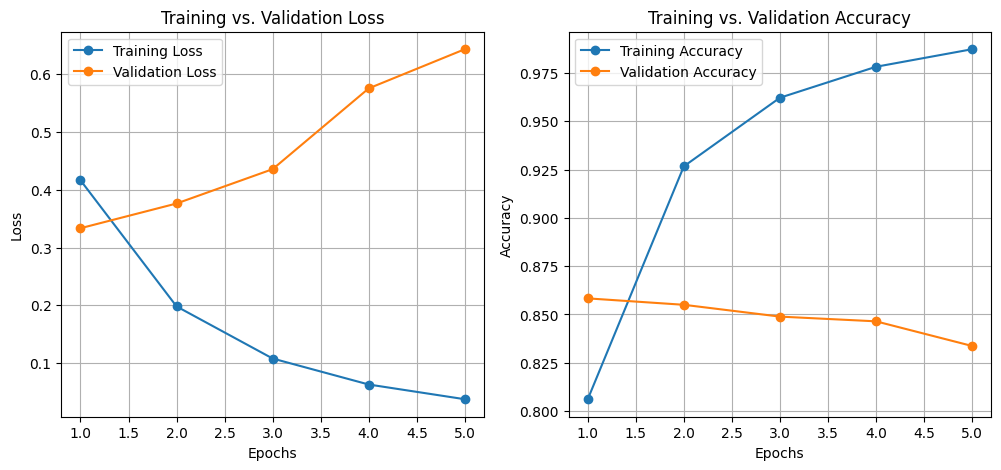

In [100]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.6701 - loss: 0.5590 - val_accuracy: 0.8519 - val_loss: 0.3370
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9246 - loss: 0.2083 - val_accuracy: 0.8492 - val_loss: 0.3358
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9668 - loss: 0.0984 - val_accuracy: 0.8489 - val_loss: 0.3788
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9824 - loss: 0.0571 - val_accuracy: 0.8374 - val_loss: 0.5301
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9889 - loss: 0.0357 - val_accuracy: 0.8438 - val_loss: 0.6962


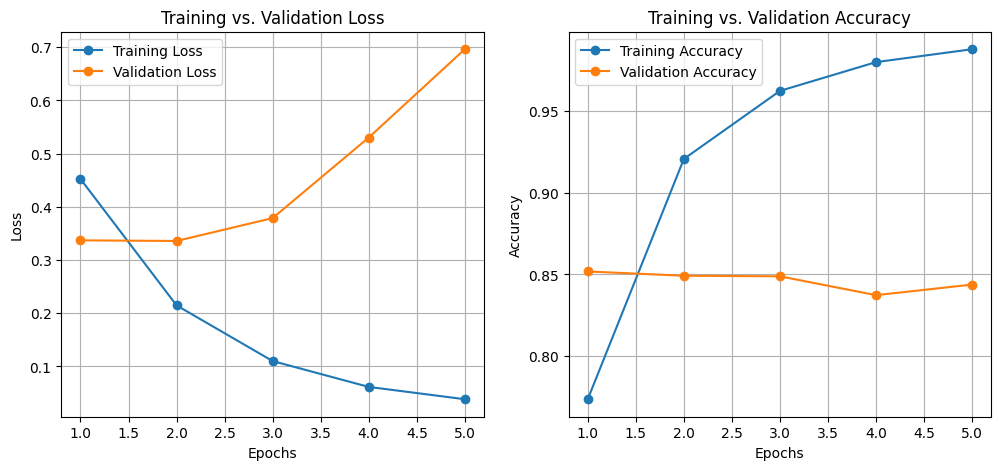

In [101]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

### How does regularization affect?

Regularization techniques like **L1** and **L2** help prevent overfitting in neural networks. These techniques add a penalty term to the loss function to control the complexity of the model. In LSTM models, regularization is applied to the weight matrices in different gates (input, forget, output, and cell state). Applying L1/L2 regularization to these weights helps prevent overfitting in sequential data.

In our tests, L1 regularization was able to help prevent overfitting. As seen from the plots, implementing L1 led to stablizing the testing loss and testing accuracy compared to the control.


**L1 Regularization (Lasso)** adds the **absolute value** of the weights to the loss function:

$$
Loss = Loss_{original} + \lambda \sum |w|
$$

- Encourages **sparsity** by driving some weights to exactly zero.
- Helps in **feature selection**, as irrelevant features may have zero weights.
- Can lead to a simpler, more interpretable model.
- Used when **sparse weight matrices** are beneficial.
- Used when you want automatic feature selection in your LSTM.

**L2 Regularization (Ridge)** adds the **squared value** of the weights to the loss function:

$$
Loss = Loss_{original} + \lambda \sum w^2
$$

- Penalizes **large weights**, but does not force them to be exactly zero.
- Distributes weight values more evenly, leading to **smoother models**.
- Helps in **handling collinearity** and prevents overfitting.
- Used when you want small but nonzero weights.
- Used when smoother and more generalizable models are preferred.


**L1 vs. L2 in LSTM Models**
- L1 Regularization: Helps remove unnecessary weights, making the model simpler.
- L2 Regularization: Helps stabilize weight values and prevents large fluctuations.
- Combination (Elastic Net): Uses both L1 and L2 to balance sparsity and stability.

#### L1 Regularization:

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6827 - loss: 6.6559 - val_accuracy: 0.8180 - val_loss: 0.6035
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8824 - loss: 0.5185 - val_accuracy: 0.8346 - val_loss: 0.5432
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9371 - loss: 0.3737 - val_accuracy: 0.8442 - val_loss: 0.5282
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9572 - loss: 0.3077 - val_accuracy: 0.8452 - val_loss: 0.5150
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9711 - loss: 0.2583 - val_accuracy: 0.8372 - val_loss: 0.5975


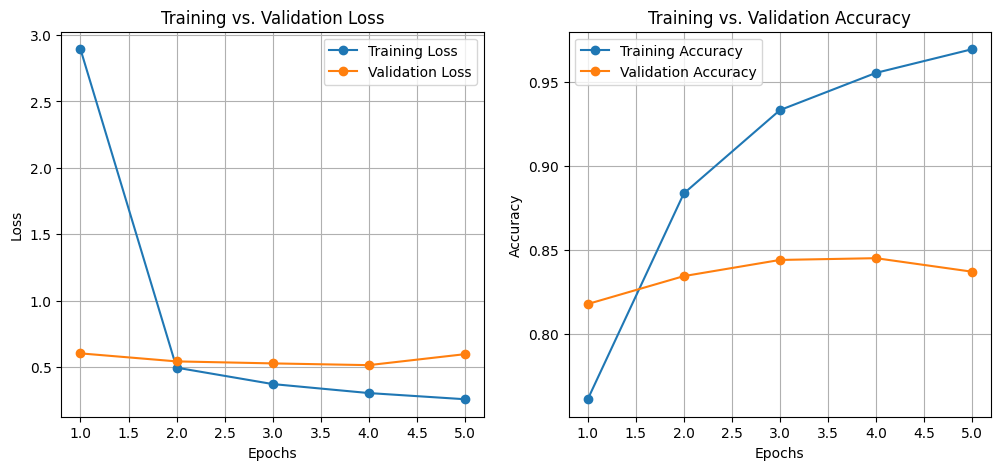

In [112]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(32, activation = 'relu', kernel_regularizer=l1(0.1)),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6560 - loss: 3.6374 - val_accuracy: 0.8339 - val_loss: 0.5229
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9009 - loss: 0.4281 - val_accuracy: 0.8412 - val_loss: 0.4744
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9474 - loss: 0.3036 - val_accuracy: 0.8368 - val_loss: 0.5160
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9666 - loss: 0.2374 - val_accuracy: 0.8485 - val_loss: 0.4864
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9762 - loss: 0.1978 - val_accuracy: 0.8424 - val_loss: 0.5117


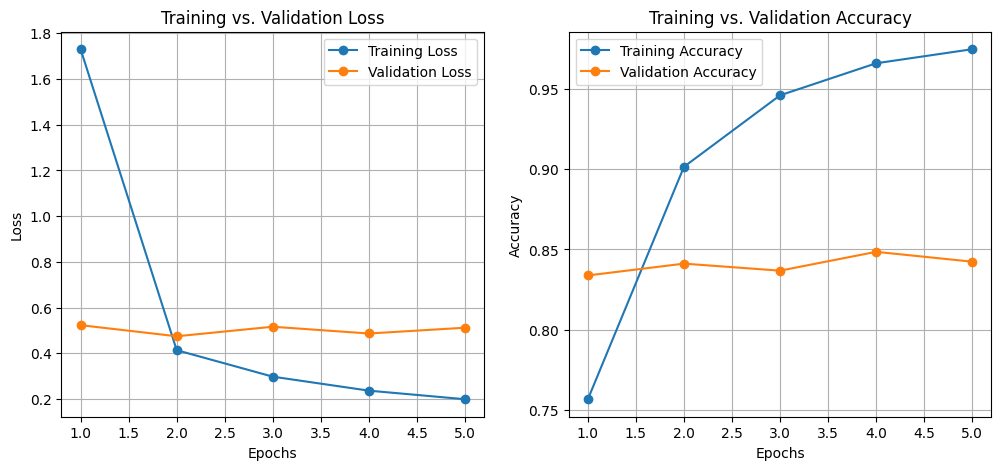

In [111]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(32, activation = 'relu', kernel_regularizer=l1(0.05)),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6657 - loss: 1.2011 - val_accuracy: 0.8185 - val_loss: 0.4401
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9170 - loss: 0.2943 - val_accuracy: 0.8505 - val_loss: 0.4057
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9620 - loss: 0.1825 - val_accuracy: 0.8443 - val_loss: 0.4854
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9782 - loss: 0.1341 - val_accuracy: 0.8513 - val_loss: 0.4979
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9840 - loss: 0.1075 - val_accuracy: 0.8473 - val_loss: 0.5412


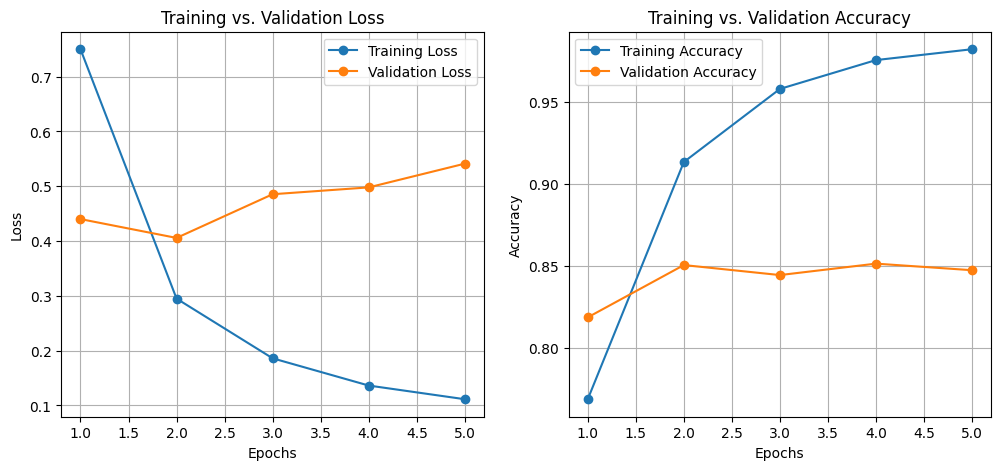

In [107]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(32, activation = 'relu', kernel_regularizer=l1(0.01)),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7213 - loss: 0.6118 - val_accuracy: 0.8522 - val_loss: 0.3803
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9295 - loss: 0.2302 - val_accuracy: 0.8431 - val_loss: 0.3938
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9669 - loss: 0.1299 - val_accuracy: 0.8496 - val_loss: 0.4421
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9815 - loss: 0.0843 - val_accuracy: 0.8422 - val_loss: 0.5495
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9888 - loss: 0.0555 - val_accuracy: 0.8438 - val_loss: 0.5790


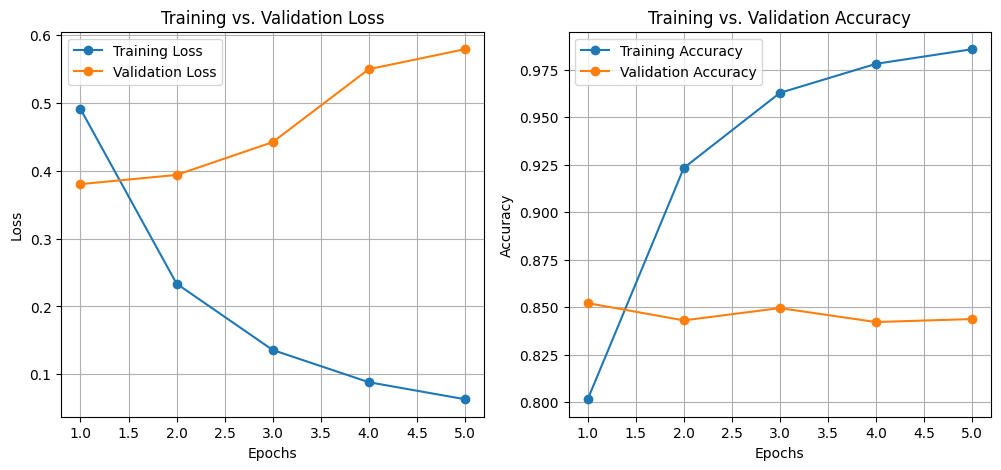

In [109]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(32, activation = 'relu', kernel_regularizer=l1(0.001)),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

#### L2 Regularization:

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.7193 - loss: 0.6433 - val_accuracy: 0.8559 - val_loss: 0.3650
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9282 - loss: 0.2127 - val_accuracy: 0.8569 - val_loss: 0.3511
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9685 - loss: 0.1073 - val_accuracy: 0.8588 - val_loss: 0.3513
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9819 - loss: 0.0714 - val_accuracy: 0.8464 - val_loss: 0.4476
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9866 - loss: 0.0512 - val_accuracy: 0.8382 - val_loss: 0.5665


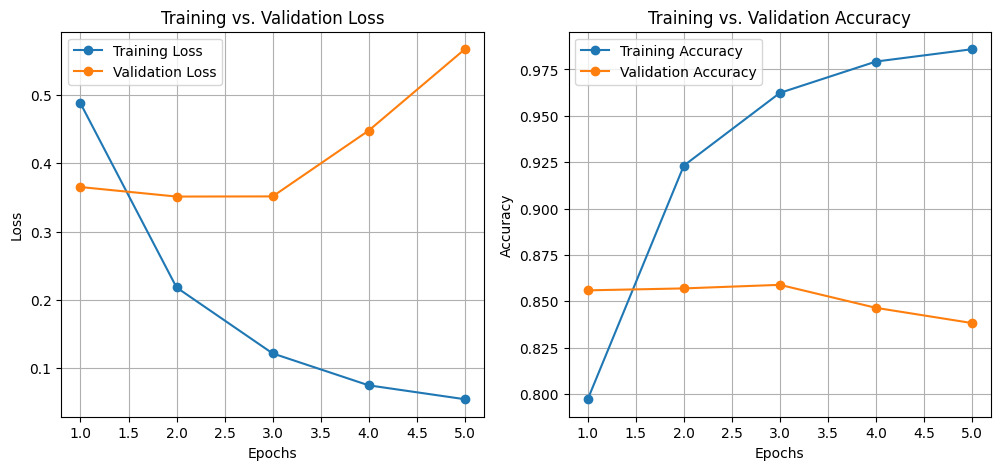

In [103]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7174 - loss: 0.5405 - val_accuracy: 0.8440 - val_loss: 0.3635
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9279 - loss: 0.2063 - val_accuracy: 0.8473 - val_loss: 0.4052
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9674 - loss: 0.1054 - val_accuracy: 0.8517 - val_loss: 0.5269
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9824 - loss: 0.0567 - val_accuracy: 0.8449 - val_loss: 0.6146
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9889 - loss: 0.0406 - val_accuracy: 0.8470 - val_loss: 0.6585


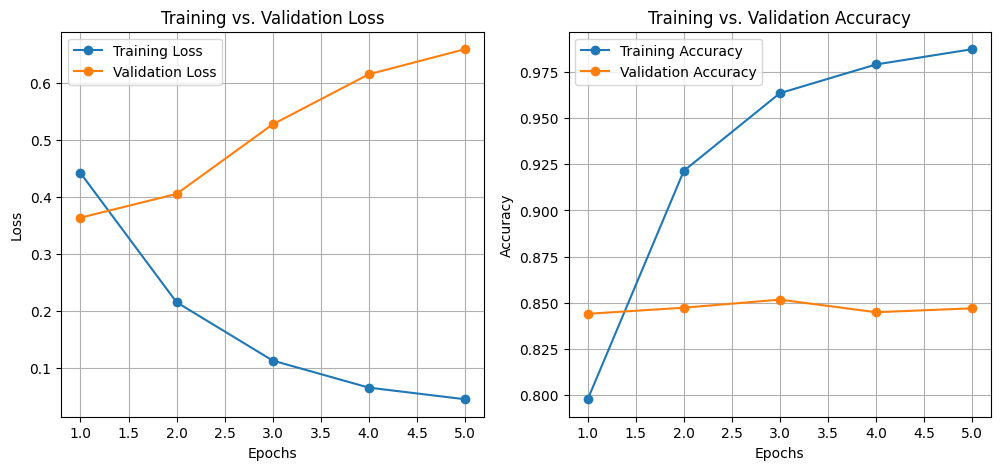

In [104]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(32, activation = 'relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

#### L1 and L2 Regularization

Epoch 1/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7043 - loss: 1.2762 - val_accuracy: 0.8508 - val_loss: 0.4252
Epoch 2/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9235 - loss: 0.2908 - val_accuracy: 0.8498 - val_loss: 0.3890
Epoch 3/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9609 - loss: 0.1837 - val_accuracy: 0.8473 - val_loss: 0.4260
Epoch 4/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9738 - loss: 0.1418 - val_accuracy: 0.8456 - val_loss: 0.4963
Epoch 5/5
716/716 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9850 - loss: 0.1076 - val_accuracy: 0.8478 - val_loss: 0.5857


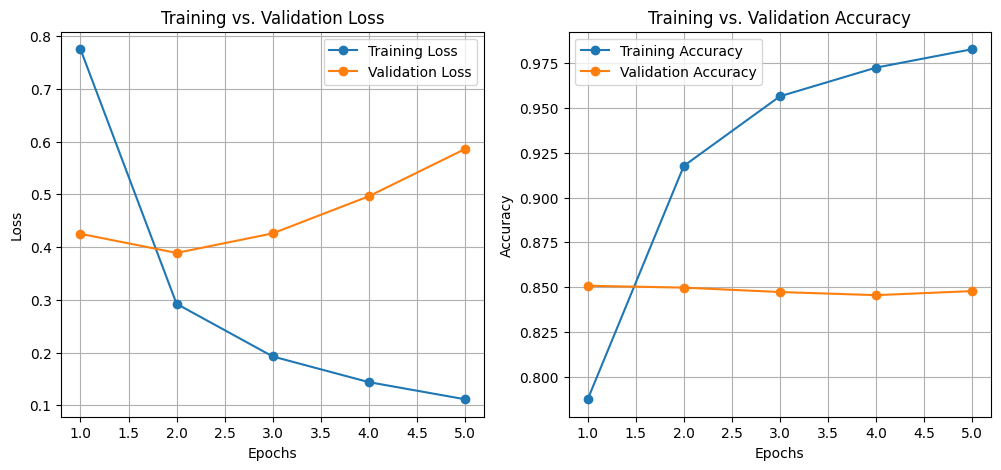

In [114]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),

    Dense(32, activation = 'relu', kernel_regularizer=l1_l2(l1 = 0.01, l2 = 0.01)),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

plot_history(history)

### Combining:
Now we'll take what we learnt from the hyperparameter tuning based on how changing different parameters affected the model in order to improve on our initial **0.859** testing accuracy.

In [120]:
checkpoint = ModelCheckpoint(
    filepath='best_sarcasm_LSTM_model.keras', 
    monitor='val_accuracy',
    save_best_only=True,      
    mode='max',             
    verbose=1     
)

In [121]:
padded_sequences = pad_sequences(sequences, maxlen=23, padding="post", truncating="post")

labels = np.array(df["is_sarcastic"])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.05, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (27188, 23)
Testing Data Shape: (1431, 23)


In [122]:
model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.5),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/5
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7360 - loss: 0.4982
Epoch 1: val_accuracy improved from -inf to 0.86164, saving model to best_sarcasm_LSTM_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.7361 - loss: 0.4980 - val_accuracy: 0.8616 - val_loss: 0.3062
Epoch 2/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9338 - loss: 0.1860
Epoch 2: val_accuracy did not improve from 0.86164
850/850 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9338 - loss: 0.1860 - val_accuracy: 0.8560 - val_loss: 0.3101
Epoch 3/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9644 - loss: 0.1055
Epoch 3: val_accuracy improved from 0.86164 to 0.86723, saving model to best_sarcasm_LSTM_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9644 - loss: 0.1055 - val_accuracy: 0.8672 - val_loss: 0.4283
Epoch 4/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9817 - loss: 0.0564
Epoch 4: val_accuracy did not improve from 0.86

In [123]:
checkpoint = ModelCheckpoint(
    filepath='best_sarcasm_LSTM_model2.keras', 
    monitor='val_accuracy',
    save_best_only=True,      
    mode='max',             
    verbose=1     
)

model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.6),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7238 - loss: 0.5121
Epoch 1: val_accuracy improved from -inf to 0.86094, saving model to best_sarcasm_LSTM_model2.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.7239 - loss: 0.5120 - val_accuracy: 0.8609 - val_loss: 0.3303
Epoch 2/5
848/850 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9294 - loss: 0.1947
Epoch 2: val_accuracy improved from 0.86094 to 0.87561, saving model to best_sarcasm_LSTM_model2.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9294 - loss: 0.1947 - val_accuracy: 0.8756 - val_loss: 0.3673
Epoch 3/5
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9632 - loss: 0.1069
Epoch 3: val_accuracy did not improve from 0.87561
850/850 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9632 - loss: 0.1070 - val_accuracy: 0.8693 - val_loss: 0.4016
Epoch 4/5
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9824 - loss: 0.0583
Epoch 4: val_accuracy did not improve from 0.

#### This is our best performing model, which training accuracy of 0.8784

In [136]:
checkpoint = ModelCheckpoint(
    filepath='best_sarcasm_LSTM_model3.keras', 
    monitor='val_accuracy',
    save_best_only=True,      
    mode='max',             
    verbose=1     
)

model = Sequential([
    
    # We add 1 because Keras reserves index 0 for padding, so we need one extra slot.
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 64),
    
    # By defult, an LSTM layer only returns last output.
    # return_sequences ensures entire sequence of output is passed to next LSTM layer. 
    LSTM(64, return_sequences = True),
    LSTM(32),
    
    Dropout(0.6),
    
    Dense(32, activation = 'relu', kernel_regularizer=l1(0.01)),
    Dense(1, activation = 'sigmoid')
    
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7201 - loss: 1.1006
Epoch 1: val_accuracy improved from -inf to 0.86024, saving model to best_sarcasm_LSTM_model3.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.7202 - loss: 1.1001 - val_accuracy: 0.8602 - val_loss: 0.3825
Epoch 2/5
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9246 - loss: 0.2845
Epoch 2: val_accuracy improved from 0.86024 to 0.87841, saving model to best_sarcasm_LSTM_model3.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9246 - loss: 0.2845 - val_accuracy: 0.8784 - val_loss: 0.3389
Epoch 3/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9580 - loss: 0.1874
Epoch 3: val_accuracy did not improve from 0.87841
850/850 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9580 - loss: 0.1874 - val_accuracy: 0.8728 - val_loss: 0.4025
Epoch 4/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9752 - loss: 0.1403
Epoch 4: val_accuracy did not improve from 0.

## Best Model Performance  

The best-performing model, from the training above, achieved our **highest testing accuracy of 87.84%**. The model configuration included:  
- **Dropout:** 0.6  
- **L1 Regularization:** 0.01
- **train/test split:** 5/95
- **Architecture:** Same LSTM and dense layers as the original model  
- **Saved Model Name:** `best_sarcasm_LSTM_model3.keras`  

### Training & Validation Metrics  
- **Training Accuracy:** 92.46%  
- **Training Loss:** 0.2845  
- **Validation Accuracy:** 87.84%  
- **Validation Loss:** 0.3389  

When re-evaluated on the full dataset, the model achieved an **accuracy of 95.55%**, which is expected since it was trained on this data.

---

### Real-World Headline Evaluation  
To further assess the model’s performance, I tested it on a mix of sarcastic and non-sarcastic headlines it had never seen before:

1. *"A new hurricane is approaching East Atlantic."* (Non-Sarcastic)
2. *"Breaking: Local Man Shocked to Discover Monday Comes Every Week."* (Sarcastic)  
3. *"Experts Warn That Doing Nothing Will Definitely Fix the Economy."* (Sarcastic)
4. *"Donald Trump executes tariffs for the U.S."* (Non-Sarcstic)
5. *"Study Finds 100% of People Eventually Die."* (Sarcastic)
6. *"Brilliant Political Plan Solves Everything, Announces Nobody."* (Sarcastic)  
7. *"New York Times columnist admits scientists ‘badly misled’ public on COVID-19: ‘Five years too late’."* (Non-Sarcstic, from Yahoo News)
8. *"Greenpeace must pay over \$660M in case over Dakota Access protest activities, jury finds"*  (Non-Sarcastic, from AP News0
9. *"Trump administration says it's cutting $175 million in funding to the University of Pennsylvania."*  (Non-Sarcastic, from CBS News)
10. *"Forgetful Man Playing Fast And Loose With Free Trials"* (Sarcastic, from TheOnion)

### Results & Observations  
The model **correctly classified 9 out of 10** headlines. The only misclassification was:  

- **Misclassified Headline:**  
  *"New York Times columnist admits scientists ‘badly misled’ public on COVID-19: ‘Five years too late’."*  

This is particularly interesting because, upon reading, I can see how it might contain subtle sarcasm, even though it is intended as a straightforward statement.  

Overall, the model performed exceptionally well on unseen data, demonstrating the power of NLP—particularly LSTMs—in capturing the nuanced aspects of the English language.

In [140]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("best_sarcasm_LSTM_model3.keras")

sequences = tokenizer.texts_to_sequences(df["cleaned_headline"])
max_length = 23 
X_full = pad_sequences(sequences, maxlen=max_length, padding='post')
y_full = df["is_sarcastic"]

loss, accuracy = model.evaluate(X_full, y_full, verbose=1)
print(f"Model Accuracy on Full Dataset: {accuracy:.4f}")
print(f"Model Loss on Full Dataset: {loss:.4f}")

895/895 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9555 - loss: 0.2268
Model Accuracy on Full Dataset: 0.9562
Model Loss on Full Dataset: 0.2256


In [146]:
sample_sentences = ["A new hurricane is approaching East Atlantic.",
                    "Breaking: Local Man Shocked to Discover Monday Comes Every Week.",
                    "Experts Warn That Doing Nothing Will Definitely Fix the Economy",
                    "Donlad Trump executes Tarrifs for the U.S.",
                    "Study Finds 100% of People Eventually Die",
                    "Brilliant Political Plan Solves Everything, Announces Nobody",
                    "New York Times columnist admits scientists ‘badly misled’ public on COVID-19: ‘Five years too late’",
                    "Greenpeace must pay over $660M in case over Dakota Access protest activities, jury finds",
                    "Trump administration says it's cutting $175 million in funding to University of Pennsylvania",
                    "Forgetful Man Playing Fast And Loose With Free Trials"
                   ]

sample_sequences = tokenizer.texts_to_sequences(sample_sentences)
max_length = 23 
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post')

predictions = model.predict(sample_padded)
predicted_labels = (predictions > 0.5).astype(int) # Convert probabilities to binary classification (0 = non-sarcastic, 1 = sarcastic)

for sentence, prediction in zip(sample_sentences, predicted_labels):
    sarcasm_label = "Sarcastic" if prediction[0] == 1 else "Not Sarcastic"
    print(f"Sentence: \"{sentence}\" → Prediction: {sarcasm_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Sentence: "A new hurricane is approaching East Atlantic." → Prediction: Not Sarcastic
Sentence: "Breaking: Local Man Shocked to Discover Monday Comes Every Week." → Prediction: Sarcastic
Sentence: "Experts Warn That Doing Nothing Will Definitely Fix the Economy" → Prediction: Sarcastic
Sentence: "Donlad Trump executes Tarrifs for the U.S." → Prediction: Not Sarcastic
Sentence: "Study Finds 100% of People Eventually Die" → Prediction: Sarcastic
Sentence: "Brilliant Political Plan Solves Everything, Announces Nobody" → Prediction: Sarcastic
Sentence: "New York Times columnist admits scientists ‘badly misled’ public on COVID-19: ‘Five years too late’" → Prediction: Sarcastic
Sentence: "Greenpeace must pay over $660M in case over Dakota Access protest activities, jury finds" → Prediction: Not Sarcastic
Sentence: "Trump administration says it's cutting $175 million in funding to University of Pennsylvania" → Prediction: Not Sarcastic
Sentence: "Forgetf